## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'agriVision-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'red'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
red_diagonal_wavelet_full_agriVision.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)

assert CWD == os.getcwd()
Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = False
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/agriVision/full/wavelet/diagonal/red'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 4500,
 3: 18000,
 4: 72000,
 5: 288000,
 6: 1152000,
 7: 4608000,
 8: 18432000,
 9: 73728000,
 10: 294912000}

Running 12760 CDFs


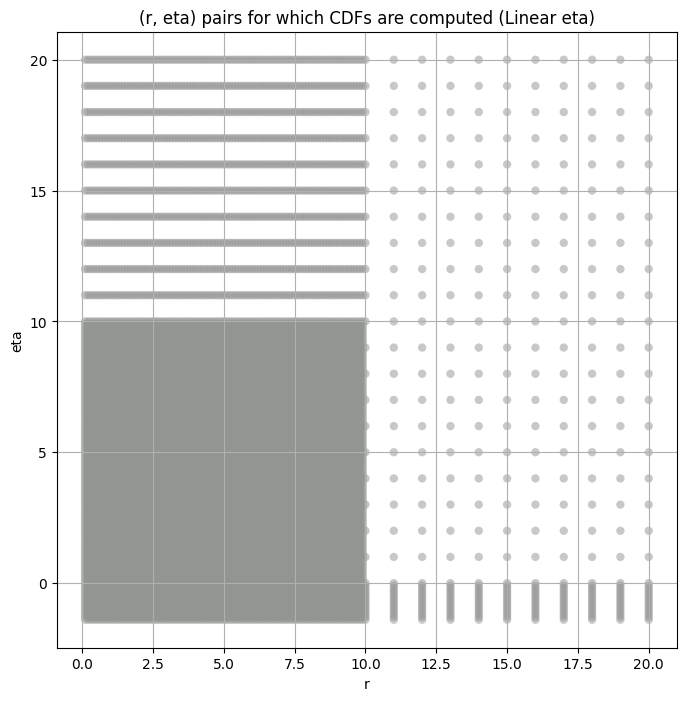

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);
all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df

Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 10


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var     var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                       
2      70756.080000  28402.766000  134955.840000    398.59210  158.815230   
3      12470.006000   7129.358000   19865.809000    397.38196  180.391070   
4       3133.784400   1051.340600    9374.212000   3015.76050  126.752686   
5        394.657000    197.559040     996.861000   1540.65990   65.792070   
6        126.877780     62.349678     502.292540   4257.31050   43.438255   
7         44.709316     23.061848     190.406900   4413.49560   35.470478   
8         13.551530      6.597639      45.296257   3008.98000   56.811893   
9          2.821836      1.154131      10.996537   4970.96880   70.242760   
10         0.345311      0.093980       1.822111  10754.93500   84.966545   

       kurt_upper  total_samples  
layer                             
2       680.61340         4500.0  
3       599.06287        18000.0  
4      4935.14900        72000.0  
5      3610.55760       288000.0  
6      6001.98600      1152000.0  
7      5876.05660      4608000.0  
8      4989.76760     18432000.0  
9      6032.67800     73728000.0  
10     7796.52540    294912000.0

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                                
2      70756.080000   70756.078125    13738.998047    10861.687500   
3      12470.006000   12470.005859     3732.257812     2980.786621   
4       3133.784400    3133.784424      968.948242      788.746948   
5        394.657000     394.657013      204.751892      177.075897   
6        126.877780     126.877777       64.575050       57.737396   
7         44.709316      44.709316       23.958195       21.733244   
8         13.551530      13.551530        6.858153        6.007334   
9          2.821836       2.821836        1.203109        1.033209   
10         0.345311       0.345311        0.098146        0.082529   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         9182.884766      7978.004883      6232.104004      5059.778320   
3         2624.995605      2381.405273      2043.630737      1811.575073   
4          704.108459       648.247559       576.901978       528.526917   
5          162.137970       151.847458       137.735413       128.062042   
6           53.787308        51.018482        47.182083        44.470287   
7           20.375097        19.391500        17.997169        17.018150   
8            5.526091         5.197854         4.759744         4.469435   
9            0.939855         0.877777         0.796682         0.743148   
10           0.074382         0.069115         0.062349         0.057898   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          4198.916504      3538.943604      3031.438232      2003.856201  
3          1635.069580      1494.347534      1376.397827      1112.833008  
4           491.792236       463.622955       440.224945       386.761932  
5           120.666214       114.765953       109.844696        98.856079  
6            42.387623        40.696251        39.273476        36.002186  
7            16.263973        15.652168        15.136086        13.936658  
8             4.256087         4.088275         3.949450         3.634765  
9             0.703459         0.671872         0.645616         0.585793  
10            0.054574         0.051910         0.049679         0.044551

####
Layer  2


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 0 0.03183395094804631 70756.08


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 25 0.017927801605164384 13738.998


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 50 0.01927482068279629 10861.6875


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 75 0.02443249405186132 9182.885


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 100 0.029170750461652295 7978.005


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 150 0.038768209526888975 6232.104


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 200 0.04847950194580755 5059.7783


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 250 0.06040094680310883 4198.9165


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 300 0.071892251784805 3538.9436


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 350 0.08330610582059114 3031.4382


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
2 500 0.1135251483660841 2003.8562
Number of samples: 4500, Without approximation : 4500.0


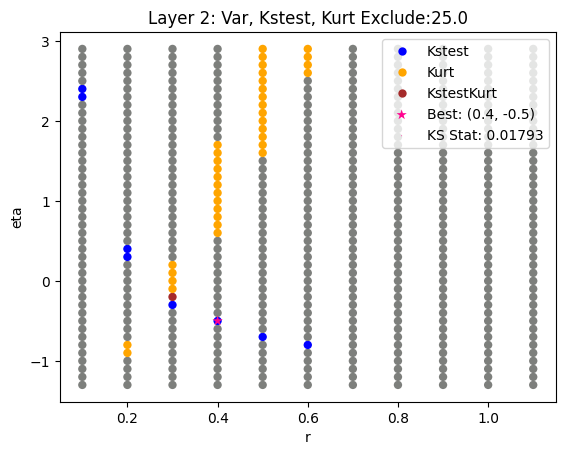

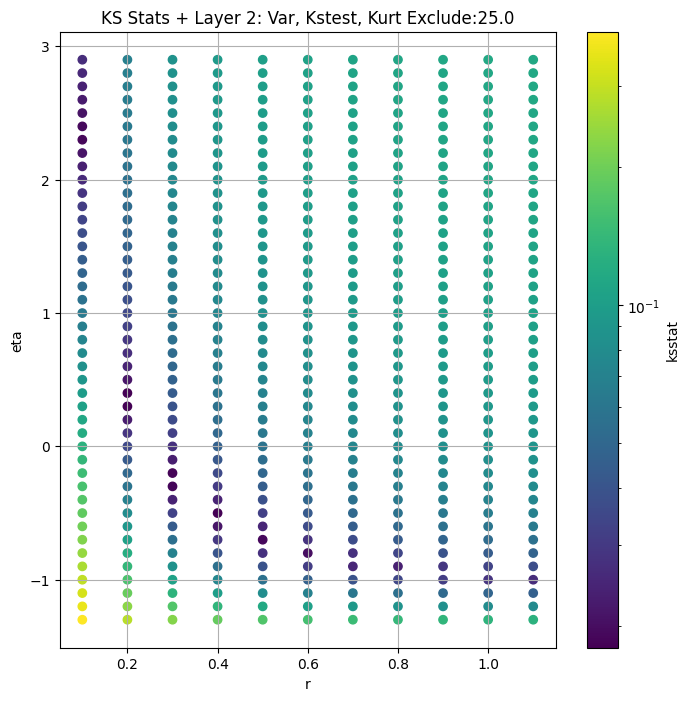

####
Layer  3


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 0 0.03212955196562045 12470.006


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 25 0.013474407062784133 3732.2578


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 50 0.012002772692713326 2980.7866


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 75 0.011000277525682223 2624.9956


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 100 0.011937172178944466 2381.4053


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 150 0.014024438590715615 2043.6307


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 200 0.016085275167673233 1811.5751


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 250 0.018764632260198977 1635.0696


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 300 0.021837980357684833 1494.3475


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 350 0.02431683520228167 1376.3978


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
3 500 0.032923033819015374 1112.833
Number of samples: 18000, Without approximation : 18000.0


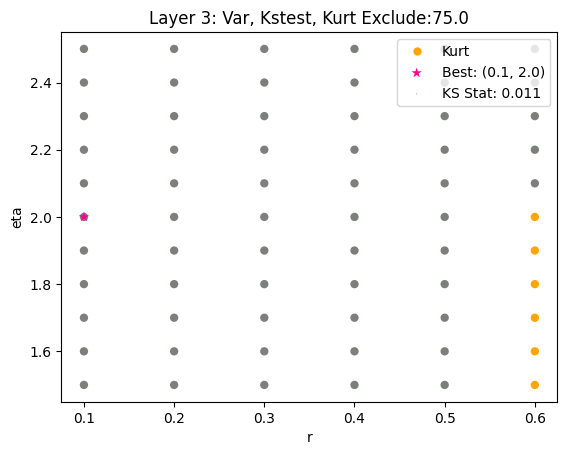

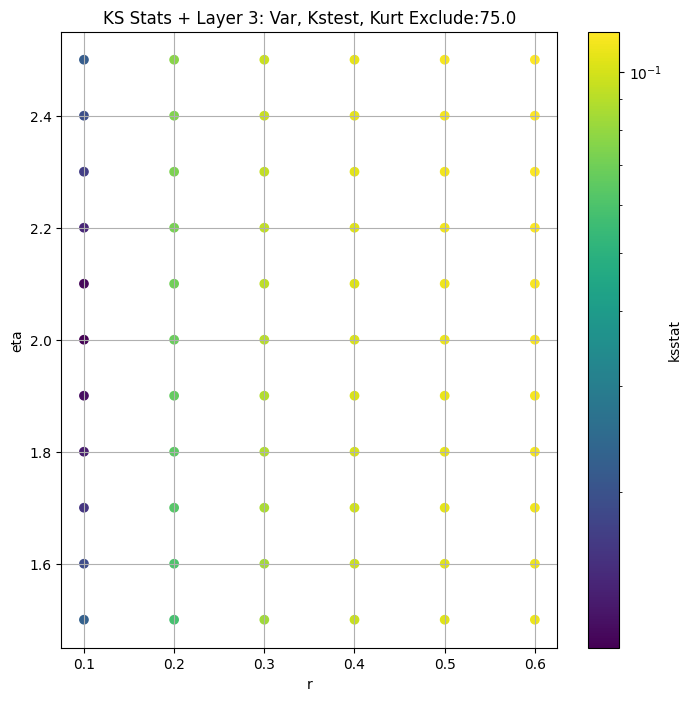

####
Layer  4


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 0 0.03928175044216786 3133.7844


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 25 0.01665653557587672 968.94824


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 50 0.011629050960004078 788.74695


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 75 0.00943373033178796 704.10846


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 100 0.009181532472186504 648.24756


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 150 0.006201343061132403 576.902


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 200 0.005548422621570626 528.5269


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 250 0.006058334774795889 491.79224


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 300 0.0067356021258240025 463.62296


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 350 0.007464080497062486 440.22495


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
4 500 0.009734907700934214 386.76193
Number of samples: 72000, Without approximation : 72000.0


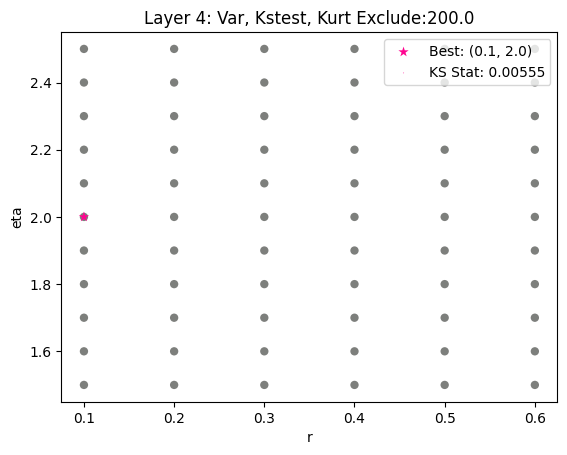

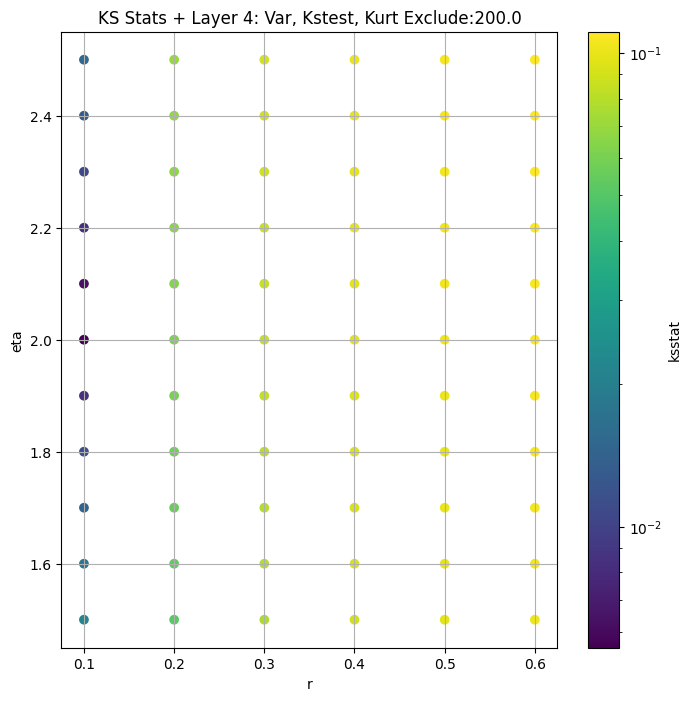

####
Layer  5


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 0 0.027496204473637542 394.657


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 25 0.015153821055815864 204.75189


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 50 0.011538328758991856 177.0759


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 75 0.008961406841618613 162.13797


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 100 0.007351521965876628 151.84746


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 150 0.005200490201007546 137.73541


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 200 0.003218346844016451 128.06204


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 250 0.003810859968967844 120.666214


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 300 0.0044116552012924415 114.76595


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 350 0.005080884992365916 109.844696


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
5 500 0.00681244794798859 98.85608
Number of samples: 100000, Without approximation : 288000.0


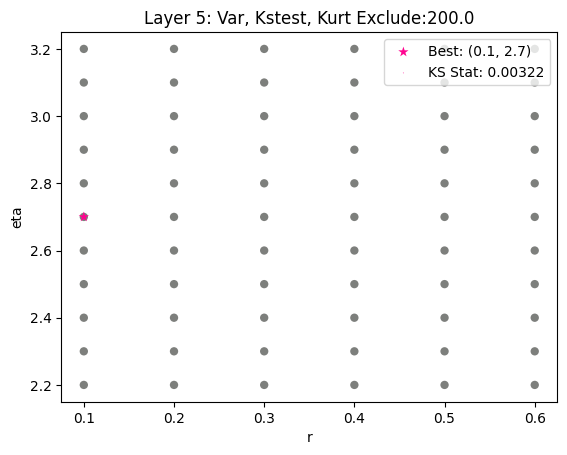

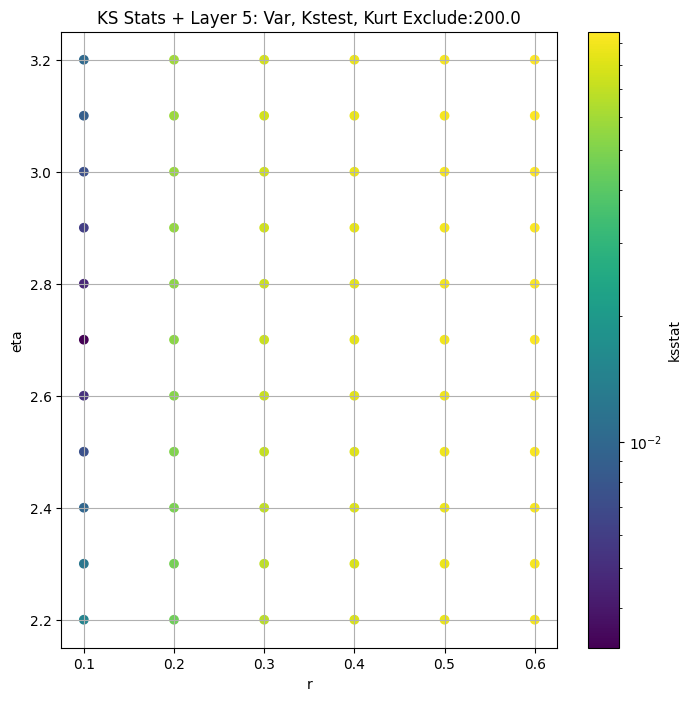

####
Layer  6


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 0 0.02565235133709065 126.87778


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 25 0.00994850050651519 64.57505


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 50 0.007487094958930296 57.737396


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 75 0.005190270935613861 53.787308


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 100 0.0038111288034419766 51.018482


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 150 0.0022973614117803853 47.182083


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 200 0.0029937516527855923 44.470287


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 250 0.0036804347186903154 42.387623


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 300 0.004445009173488031 40.69625


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 350 0.005053772336009484 39.273476


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
6 500 0.00681080517973732 36.002186
Number of samples: 100000, Without approximation : 1152000.0


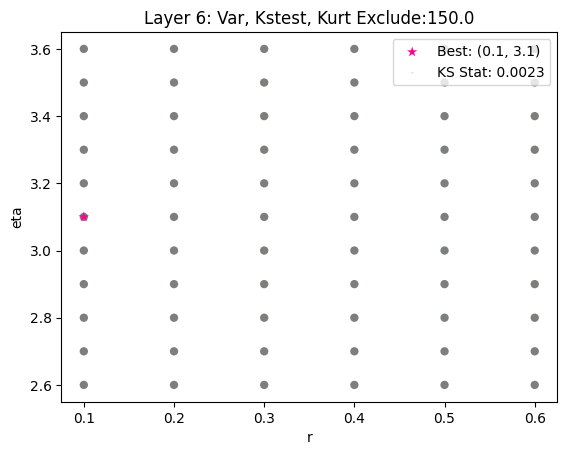

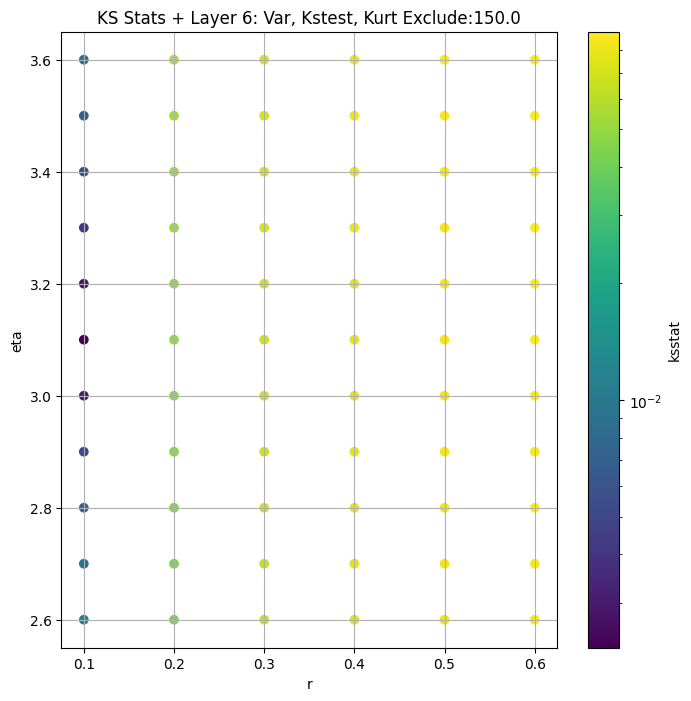

####
Layer  7


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 0 0.022819551425225293 44.709316


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 25 0.008272439030916734 23.958195


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 50 0.00552101666625196 21.733244


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 75 0.0037205518673957827 20.375097


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 100 0.002680034774505763 19.3915


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 150 0.002185396514175429 17.99717


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 200 0.002924840647127811 17.01815


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 250 0.00357502630064184 16.263973


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 300 0.004329831047243344 15.652168


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 350 0.004930397365585133 15.136086


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
7 500 0.006888365201777795 13.936658
Number of samples: 100000, Without approximation : 4608000.0


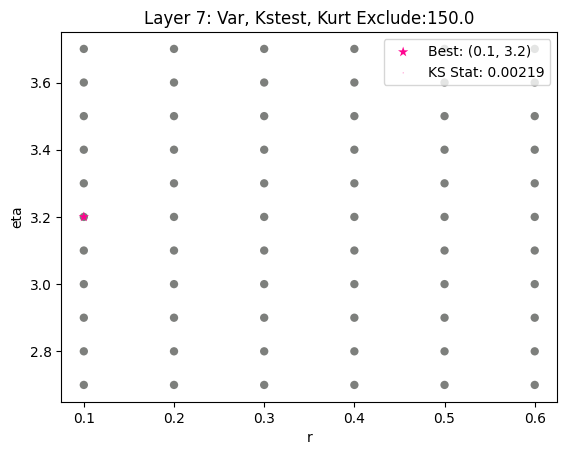

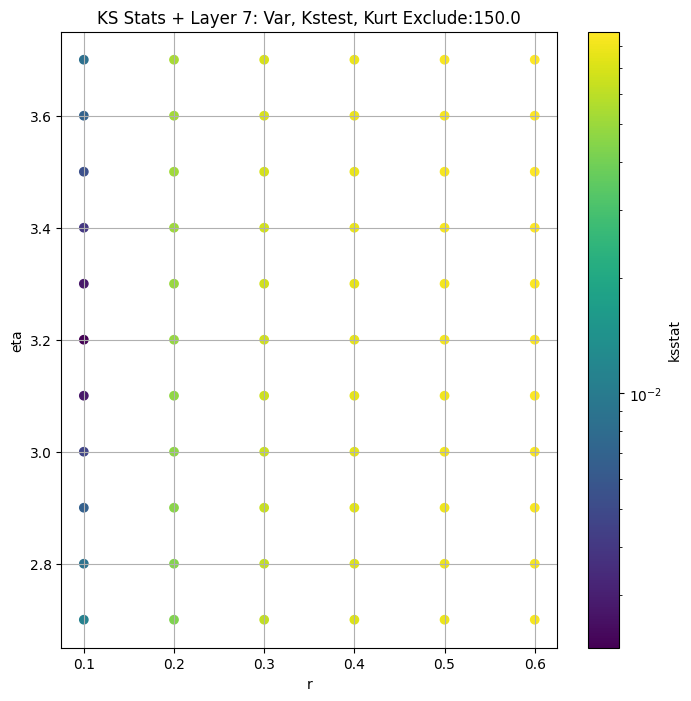

####
Layer  8


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 0 0.025271319314202546 13.55153


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 25 0.010946311324473323 6.858153


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 50 0.007374585588827753 6.0073338


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 75 0.00506194892859424 5.5260906


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 100 0.0036180979654545364 5.197854


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 150 0.0020134345824070012 4.759744


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 200 0.002628568571512193 4.4694347


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 250 0.0034040565244125576 4.256087


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 300 0.004090293278673607 4.0882754


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 350 0.004809619814724497 3.94945


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
8 500 0.00682807908067018 3.6347651
Number of samples: 100000, Without approximation : 18432000.0


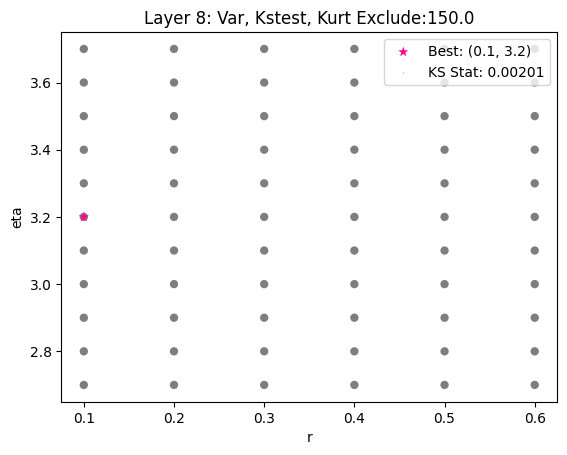

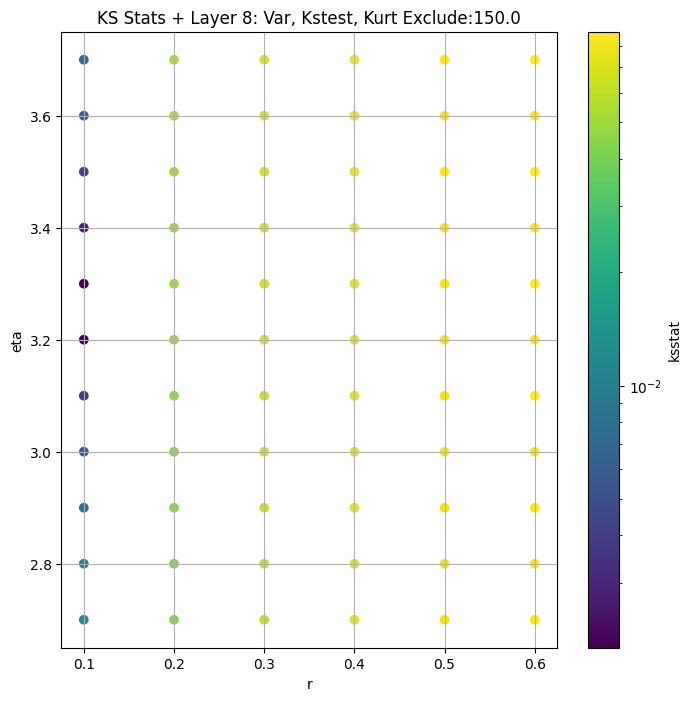

####
Layer  9


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 0 0.03306103959969686 2.8218355


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 25 0.014765407110858497 1.2031094


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 50 0.011807028590947621 1.0332091


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 75 0.008936981633674401 0.9398547


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 100 0.007239288041472891 0.87777704


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 150 0.005632415864614493 0.7966816


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 200 0.0038972164587809943 0.74314785


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 250 0.004050117295658073 0.7034587


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 300 0.004697803688462954 0.6718725


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 350 0.00535945012560457 0.6456159


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
9 500 0.007253061107317826 0.585793
Number of samples: 100000, Without approximation : 73728000.0


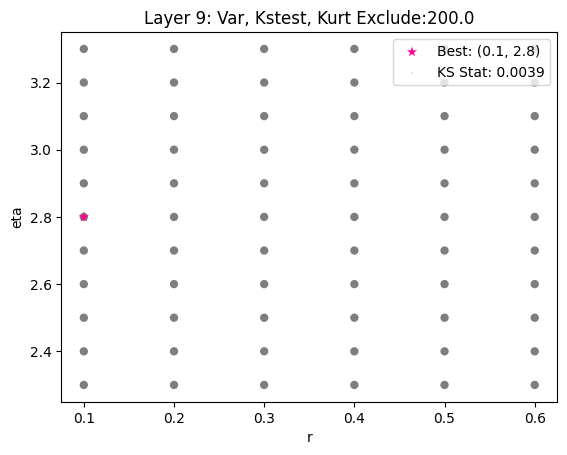

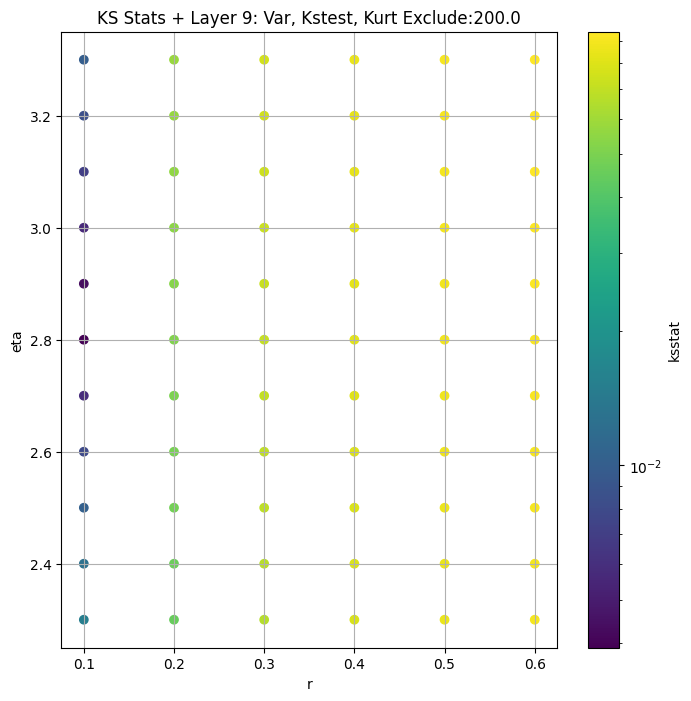

####
Layer  10


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 0 0.042550368820382434 0.34531063


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 25 0.019534649315513075 0.09814584


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 50 0.015363158611267247 0.08252873


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 75 0.013276452532631655 0.07438154


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 100 0.011784032402242878 0.06911478


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 150 0.009869086711548403 0.062349353


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 200 0.00838802721996712 0.05789827


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 250 0.006802953003153839 0.054574057


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 300 0.006638350877958776 0.051909663


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 350 0.0065963955413595385 0.04967893


  0%|          | 0/12760 [00:00<?, ?it/s]

Finding Minimum after computing 12760 CDFs
10 500 0.008084597666586032 0.04455078
Number of samples: 100000, Without approximation : 294912000.0


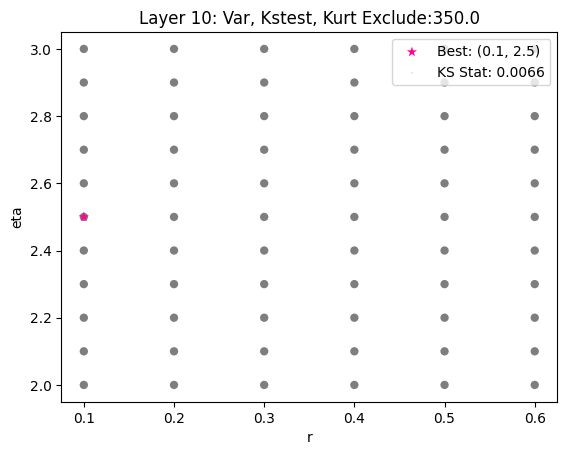

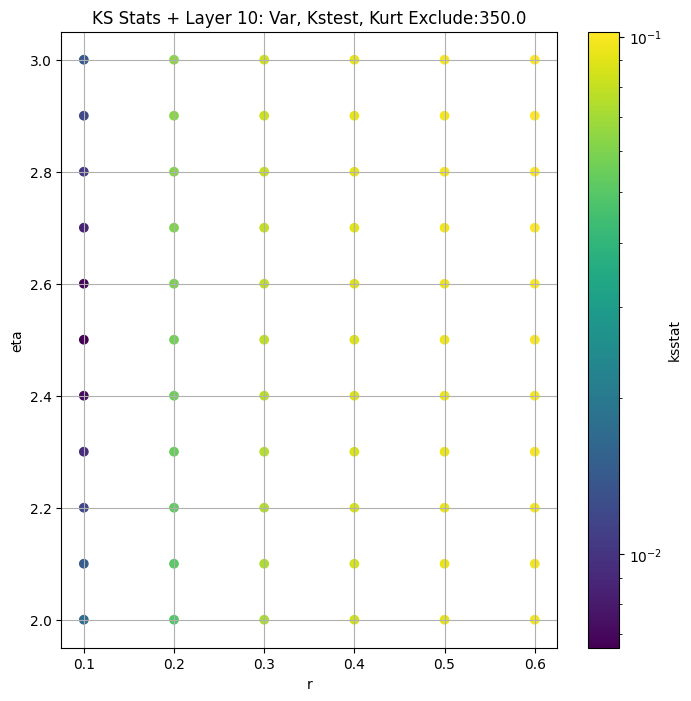

obs_var     var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                       
2      70756.080000  28402.766000  134955.840000    398.59210  158.815230   
3      12470.006000   7129.358000   19865.809000    397.38196  180.391070   
4       3133.784400   1051.340600    9374.212000   3015.76050  126.752686   
5        394.657000    197.559040     996.861000   1540.65990   65.792070   
6        126.877780     62.349678     502.292540   4257.31050   43.438255   
7         44.709316     23.061848     190.406900   4413.49560   35.470478   
8         13.551530      6.597639      45.296257   3008.98000   56.811893   
9          2.821836      1.154131      10.996537   4970.96880   70.242760   
10         0.345311      0.093980       1.822111  10754.93500   84.966545   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       680.61340         4500.0             0.017928        0.4         -0.5   
3       599.06287        18000.0             0.011000        0.1          2.0   
4      4935.14900        72000.0             0.005548        0.1          2.0   
5      3610.55760       288000.0             0.003218        0.1          2.7   
6      6001.98600      1152000.0             0.002297        0.1          3.1   
7      5876.05660      4608000.0             0.002185        0.1          3.2   
8      4989.76760     18432000.0             0.002013        0.1          3.2   
9      6032.67800     73728000.0             0.003897        0.1          2.8   
10     7796.52540    294912000.0             0.006596        0.1          2.5   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       7.609919e+02                    25.0        13738.998000   
3       2.915371e-13                    75.0         2624.995600   
4       5.869922e-14                   200.0          528.526900   
5       2.761877e-15                   200.0          128.062040   
6       4.445374e-16                   150.0           47.182083   
7       1.392853e-16                   150.0           17.997170   
8       3.683703e-17                   150.0            4.759744   
9       1.294509e-17                   200.0            0.743148   
10      1.665913e-18                   350.0            0.049679   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.020208  
3                     0.010113  
4                     0.005059  
5                     0.002530  
6                     0.001265  
7                     0.000633  
8                     0.000316  
9                     0.000158  
10                    0.000079

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
                
            group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    master_df.to_csv(master_df_combo_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    augmented_var_df.to_csv(augmented_var_df_path)

augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 2, 25.0 + 100 = 125, ksstat: 0.03581223522864663, var: 7007.5908203125


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 2, 25.0 + 75 = 100, ksstat: 0.03050182619887598, var: 7978.0048828125


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 2, 25.0 + 50 = 75, ksstat: 0.025110502001670976, var: 9182.884765625


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 2, 25.0 + 25 = 50, ksstat: 0.019151128344338464, var: 10861.6875


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 2, 25.0 + 0 = 25, ksstat: 0.017927801605164384, var: 13738.998046875


  0%|          | 0/1512 [00:00<?, ?it/s]

Finding Minimum after computing 1512 CDFs
layer 2, 25.0 + -25 = 0, ksstat: 0.033327649054645164, var: 70756.078125
Number of samples: 4500, Without approximation : 4500.0


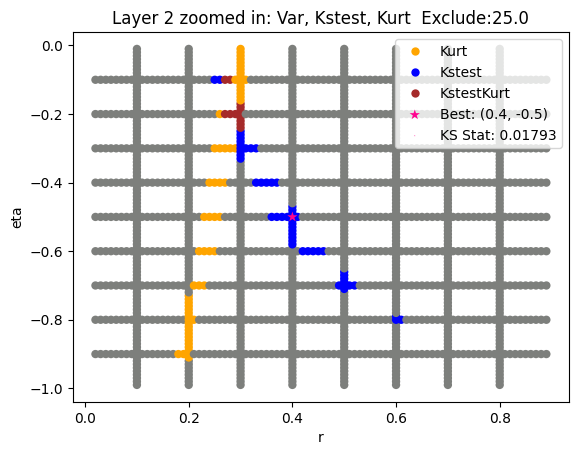

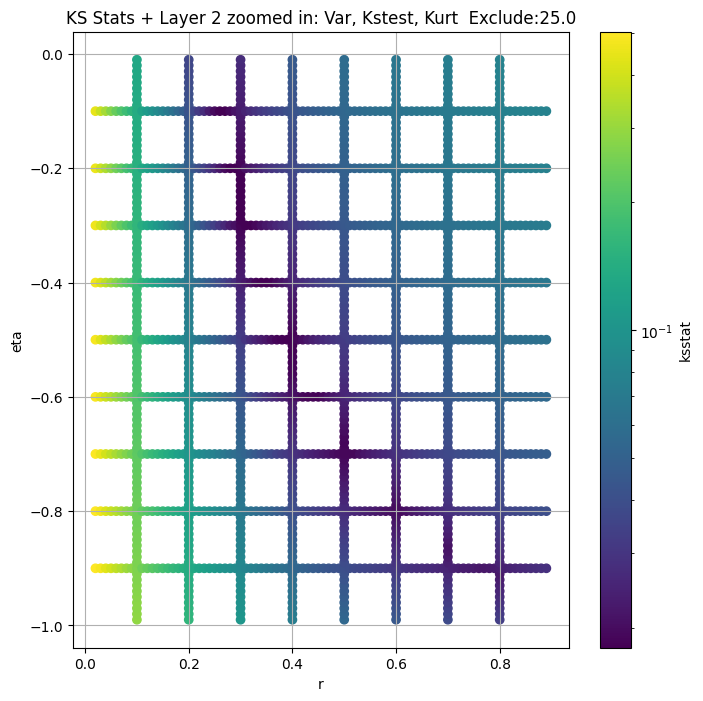

Layer 3


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 75.0 + 100 = 175, ksstat: 0.017708418145339674, var: 1917.74365234375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 75.0 + 75 = 150, ksstat: 0.015865895381401693, var: 2043.6307373046875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 75.0 + 50 = 125, ksstat: 0.013896119125832038, var: 2196.978271484375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 75.0 + 25 = 100, ksstat: 0.011858475274167654, var: 2381.4052734375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 75.0 + 0 = 75, ksstat: 0.010774194173982454, var: 2624.99560546875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 75.0 + -25 = 50, ksstat: 0.011593192954528209, var: 2980.78662109375


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 75.0 + -50 = 25, ksstat: 0.01321378915271787, var: 3732.2578125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 3, 75.0 + -75 = 0, ksstat: 0.02919127785014275, var: 12470.005859375
Number of samples: 18000, Without approximation : 18000.0


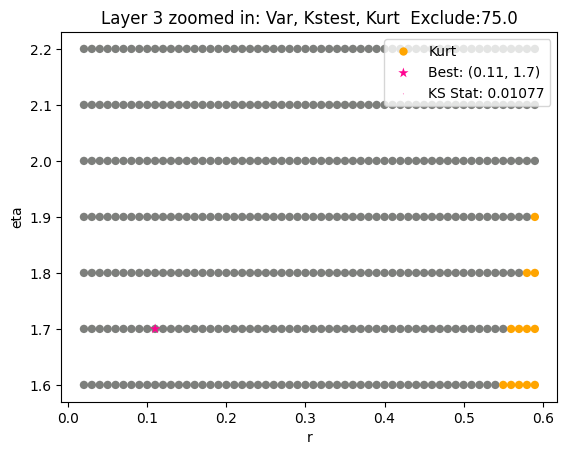

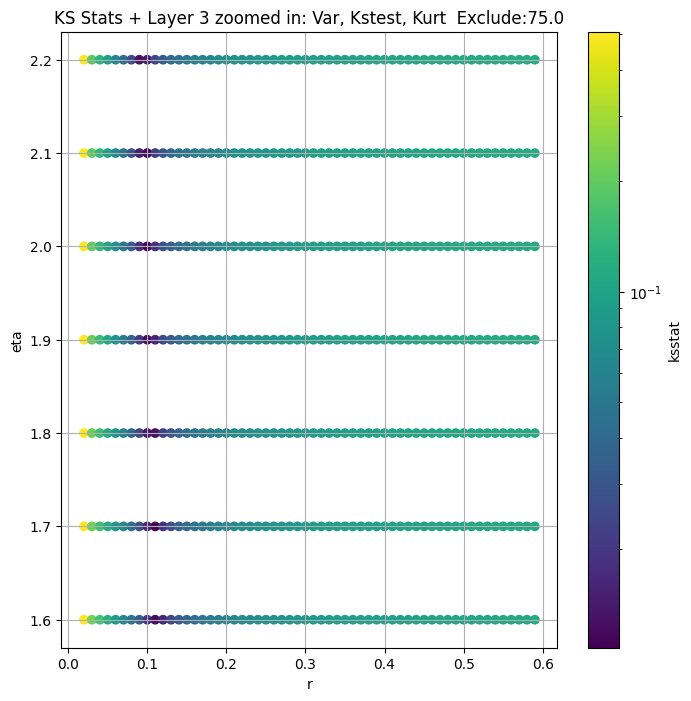

Layer 4


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 200.0 + 100 = 300, ksstat: 0.006922031957689421, var: 463.6229553222656


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 200.0 + 75 = 275, ksstat: 0.006467556682051508, var: 476.8761291503906


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 200.0 + 50 = 250, ksstat: 0.005987435568563132, var: 491.792236328125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 200.0 + 25 = 225, ksstat: 0.005472378335505087, var: 508.8628234863281


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 200.0 + 0 = 200, ksstat: 0.0051280833368560486, var: 528.5269165039062


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 200.0 + -25 = 175, ksstat: 0.0057543340336980164, var: 550.8553466796875


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 200.0 + -50 = 150, ksstat: 0.005764623429803217, var: 576.9019775390625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 200.0 + -75 = 125, ksstat: 0.007145250832760713, var: 608.3590087890625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 4, 200.0 + -100 = 100, ksstat: 0.007710418421489229, var: 648.24755859375
Number of samples: 72000, Without approximation : 72000.0


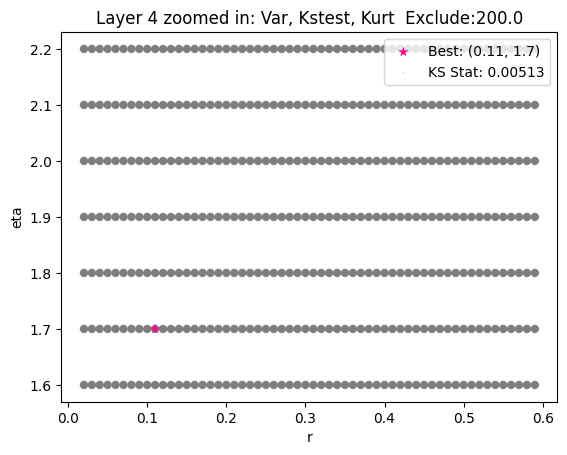

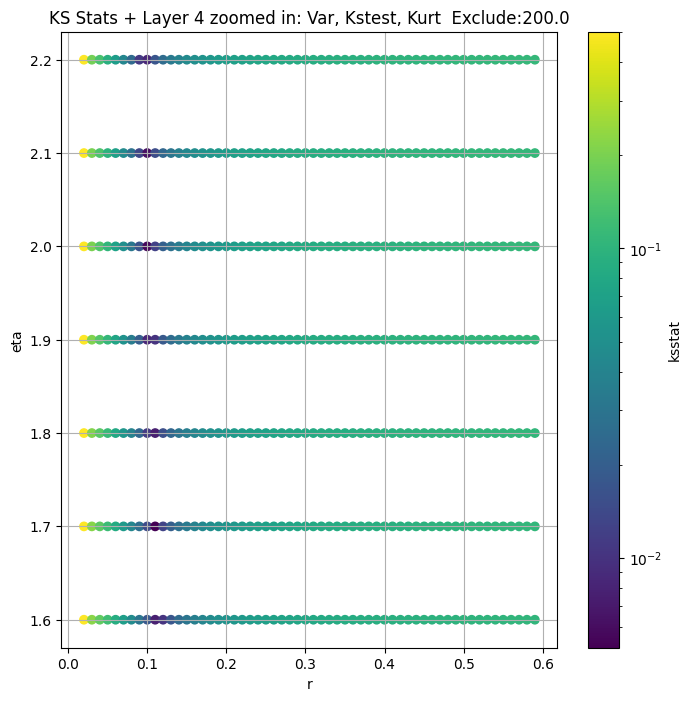

Layer 5


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 200.0 + 100 = 300, ksstat: 0.004460709990275705, var: 114.76595306396484


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 200.0 + 75 = 275, ksstat: 0.004149879602358042, var: 117.55513000488281


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 200.0 + 50 = 250, ksstat: 0.003810859968967844, var: 120.66621398925781


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 200.0 + 25 = 225, ksstat: 0.003473108657936671, var: 124.13735961914062


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 200.0 + 0 = 200, ksstat: 0.003218346844016451, var: 128.06204223632812


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 200.0 + -25 = 175, ksstat: 0.00438339522188913, var: 132.5477752685547


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 200.0 + -50 = 150, ksstat: 0.004690775461926422, var: 137.73541259765625


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 200.0 + -75 = 125, ksstat: 0.0057280378119632935, var: 144.0479736328125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 5, 200.0 + -100 = 100, ksstat: 0.0071144613463622886, var: 151.8474578857422
Number of samples: 100000, Without approximation : 288000.0


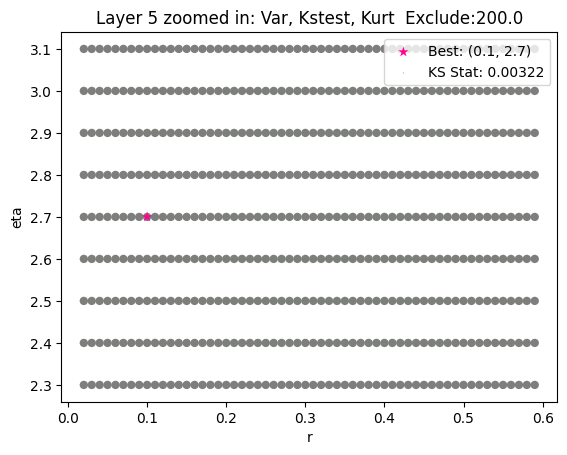

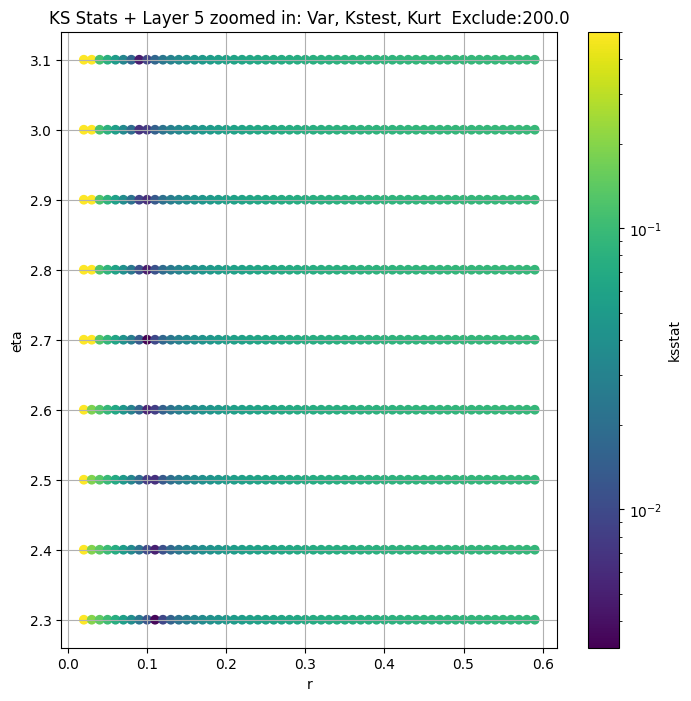

Layer 6


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + 100 = 250, ksstat: 0.0038295432815450402, var: 42.38762283325195


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + 75 = 225, ksstat: 0.003397880435349993, var: 43.36842727661133


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + 50 = 200, ksstat: 0.002992943206007412, var: 44.47028732299805


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + 25 = 175, ksstat: 0.0026267830466425238, var: 45.728458404541016


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + 0 = 150, ksstat: 0.0022973614117803853, var: 47.18208312988281


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + -25 = 125, ksstat: 0.002608336401781375, var: 48.90626525878906


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + -50 = 100, ksstat: 0.0035594589607222393, var: 51.01848220825195


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + -75 = 75, ksstat: 0.005157257969263029, var: 53.78730773925781


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 6, 150.0 + -100 = 50, ksstat: 0.006851057917610592, var: 57.737396240234375
Number of samples: 100000, Without approximation : 1152000.0


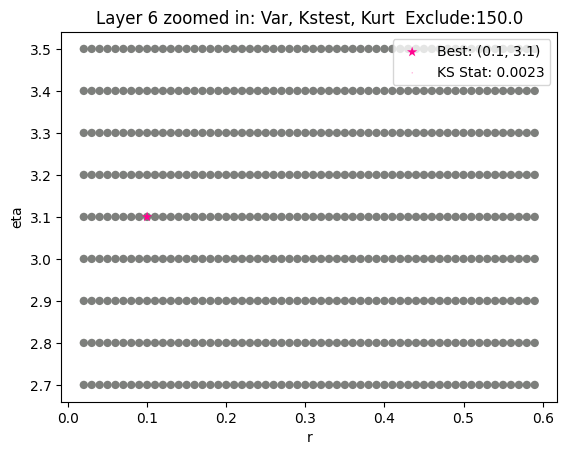

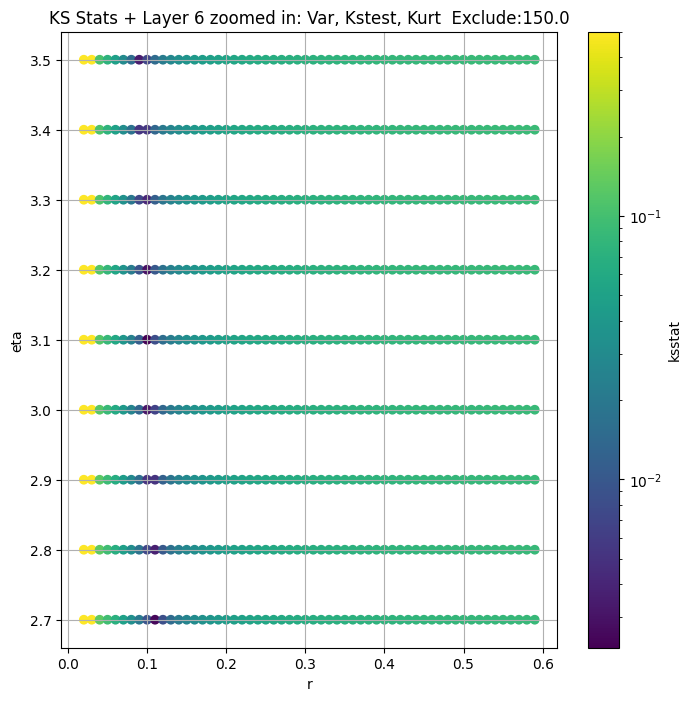

Layer 7


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 100 = 250, ksstat: 0.003945223871372406, var: 16.263973236083984


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 75 = 225, ksstat: 0.003470535424039408, var: 16.61945915222168


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 50 = 200, ksstat: 0.002960182235881452, var: 17.018150329589844


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 25 = 175, ksstat: 0.0025331464024045958, var: 17.47172737121582


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + 0 = 150, ksstat: 0.002185396514175429, var: 17.997169494628906


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -25 = 125, ksstat: 0.0018895683777537808, var: 18.62237548828125


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -50 = 100, ksstat: 0.002326625401158522, var: 19.39150047302246


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -75 = 75, ksstat: 0.003270929510156187, var: 20.375097274780273


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 7, 150.0 + -100 = 50, ksstat: 0.004753541485893395, var: 21.733243942260742
Number of samples: 100000, Without approximation : 4608000.0


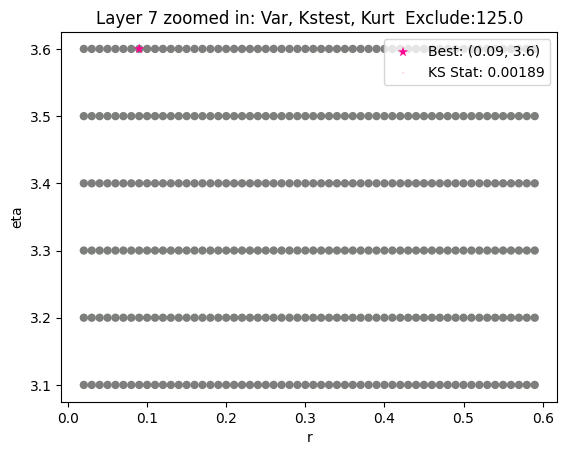

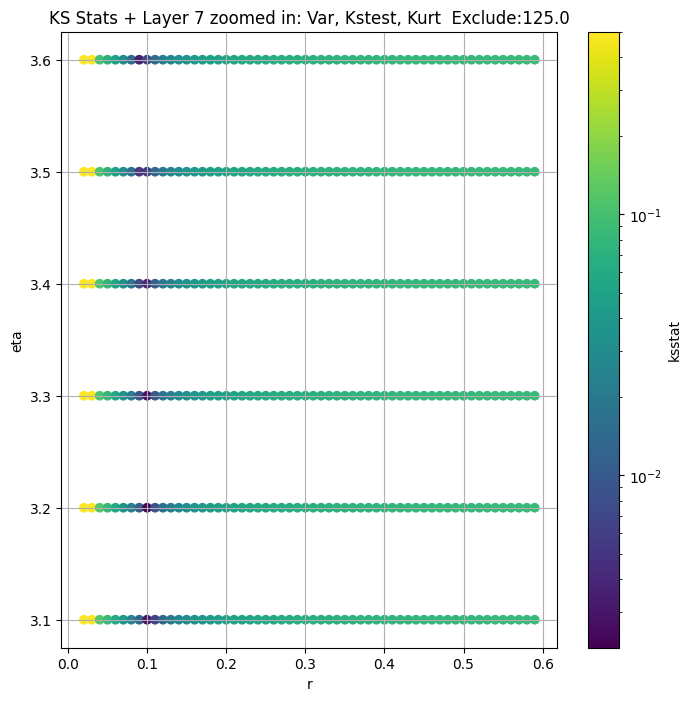

Layer 8


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 100 = 250, ksstat: 0.0037630887667763346, var: 4.256086826324463


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 75 = 225, ksstat: 0.0031800564688636568, var: 4.355660915374756


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 50 = 200, ksstat: 0.0026374669390801797, var: 4.46943473815918


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 25 = 175, ksstat: 0.002280384608406849, var: 4.601912021636963


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + 0 = 150, ksstat: 0.0020134345824070012, var: 4.759744167327881


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -25 = 125, ksstat: 0.0017860258467190526, var: 4.952874183654785


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -50 = 100, ksstat: 0.0033992620233124216, var: 5.197854042053223


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -75 = 75, ksstat: 0.004947621314387418, var: 5.526090621948242


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 8, 150.0 + -100 = 50, ksstat: 0.006762463524131235, var: 6.007333755493164
Number of samples: 100000, Without approximation : 18432000.0


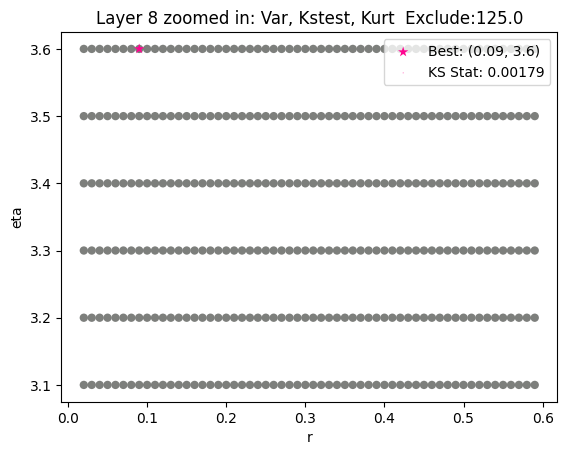

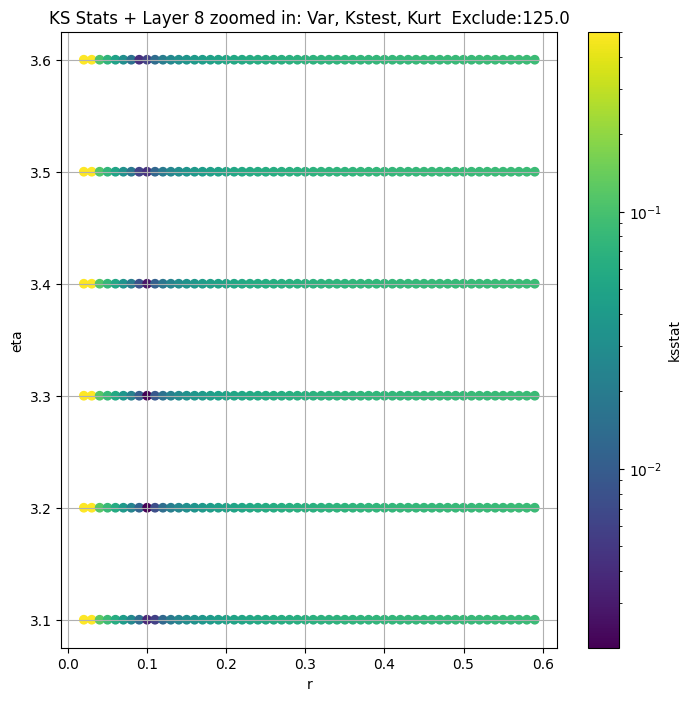

Layer 9


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 100 = 300, ksstat: 0.004819690623305117, var: 0.6718724966049194


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 75 = 275, ksstat: 0.00444689277510979, var: 0.6868655681610107


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 50 = 250, ksstat: 0.004040159372806107, var: 0.7034587264060974


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 25 = 225, ksstat: 0.0036297908146173397, var: 0.7220321297645569


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + 0 = 200, ksstat: 0.0038399570638504854, var: 0.7431478500366211


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -25 = 175, ksstat: 0.004020385791768, var: 0.7676271796226501


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -50 = 150, ksstat: 0.0051629260625631335, var: 0.7966815829277039


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -75 = 125, ksstat: 0.006163846926619643, var: 0.8322445154190063


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 9, 200.0 + -100 = 100, ksstat: 0.006727677511284003, var: 0.8777770400047302
Number of samples: 100000, Without approximation : 73728000.0


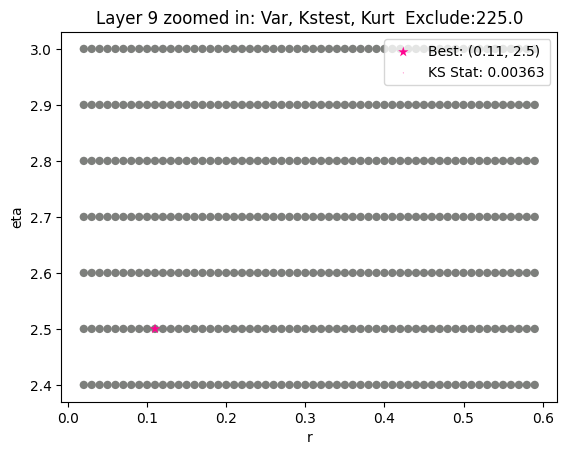

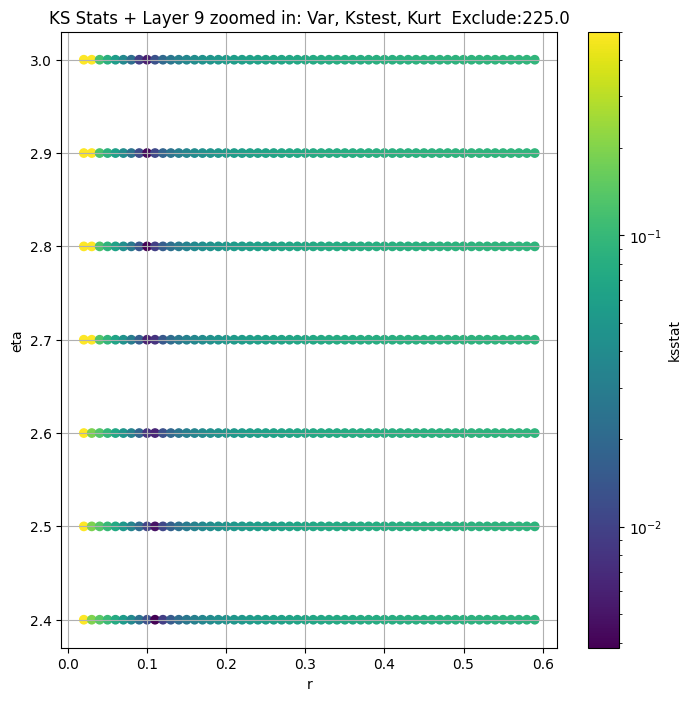

Layer 10


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + 100 = 450, ksstat: 0.007999232736167008, var: 0.046063054352998734


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + 75 = 425, ksstat: 0.007634966186513263, var: 0.046884164214134216


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + 50 = 400, ksstat: 0.007313452422029212, var: 0.047755613923072815


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + 25 = 375, ksstat: 0.006933134995881007, var: 0.048684440553188324


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + 0 = 350, ksstat: 0.006543905638293202, var: 0.04967892915010452


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + -25 = 325, ksstat: 0.006196988278653955, var: 0.05074954032897949


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + -50 = 300, ksstat: 0.005834113237520054, var: 0.051909662783145905


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + -75 = 275, ksstat: 0.006477074446031739, var: 0.05317670851945877


  0%|          | 0/522 [00:00<?, ?it/s]

Finding Minimum after computing 522 CDFs
layer 10, 350.0 + -100 = 250, ksstat: 0.006802953003153839, var: 0.05457405745983124
Number of samples: 100000, Without approximation : 294912000.0


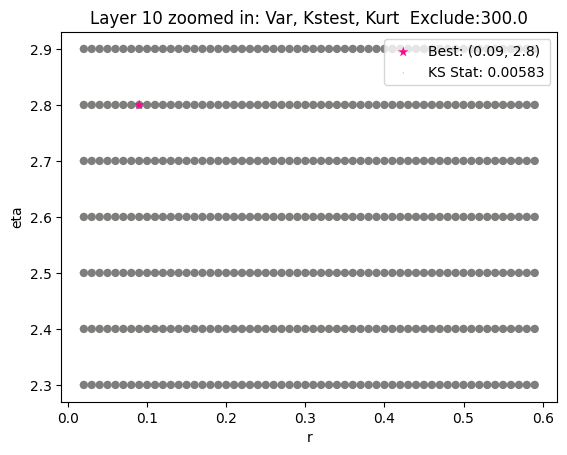

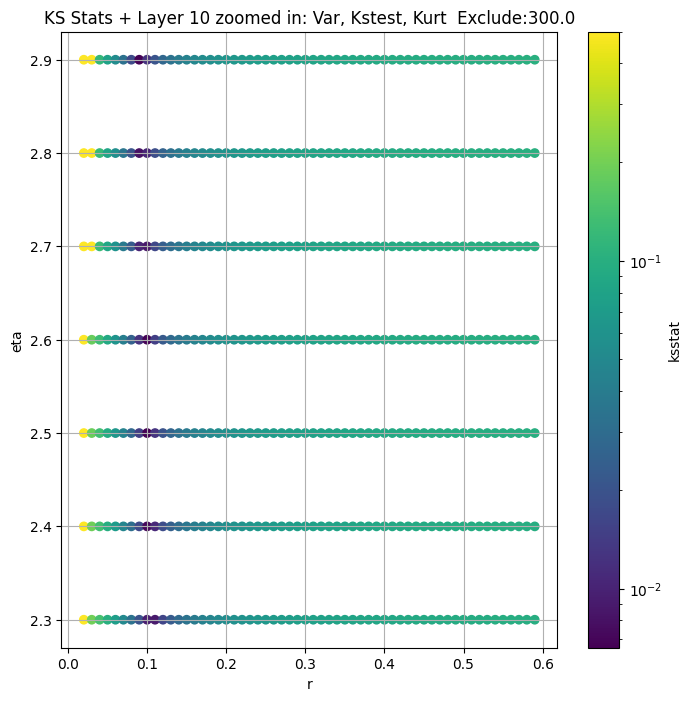

obs_var     var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                       
2      70756.080000  28402.766000  134955.840000    398.59210  158.815230   
3      12470.006000   7129.358000   19865.809000    397.38196  180.391070   
4       3133.784400   1051.340600    9374.212000   3015.76050  126.752686   
5        394.657000    197.559040     996.861000   1540.65990   65.792070   
6        126.877780     62.349678     502.292540   4257.31050   43.438255   
7         44.709316     23.061848     190.406900   4413.49560   35.470478   
8         13.551530      6.597639      45.296257   3008.98000   56.811893   
9          2.821836      1.154131      10.996537   4970.96880   70.242760   
10         0.345311      0.093980       1.822111  10754.93500   84.966545   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       680.61340         4500.0             0.017928        0.4         -0.5   
3       599.06287        18000.0             0.011000        0.1          2.0   
4      4935.14900        72000.0             0.005548        0.1          2.0   
5      3610.55760       288000.0             0.003218        0.1          2.7   
6      6001.98600      1152000.0             0.002297        0.1          3.1   
7      5876.05660      4608000.0             0.002185        0.1          3.2   
8      4989.76760     18432000.0             0.002013        0.1          3.2   
9      6032.67800     73728000.0             0.003897        0.1          2.8   
10     7796.52540    294912000.0             0.006596        0.1          2.5   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2       7.609919e+02                    25.0        13738.998000   
3       2.915371e-13                    75.0         2624.995605   
4       5.869922e-14                   200.0          528.526917   
5       2.761877e-15                   200.0          128.062040   
6       4.445374e-16                   150.0           47.182083   
7       1.392853e-16                   150.0           18.622375   
8       3.683703e-17                   150.0            4.952874   
9       1.294509e-17                   200.0            0.722032   
10      1.665913e-18                   350.0            0.051910   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.020208          0.017928    0.40      -0.5   
3                     0.010113          0.010774    0.11       1.7   
4                     0.005059          0.005128    0.11       1.7   
5                     0.002530          0.003218    0.10       2.7   
6                     0.001265          0.002297    0.10       3.1   
7                     0.000633          0.001890    0.09       3.6   
8                     0.000316          0.001786    0.09       3.6   
9                     0.000158          0.003630    0.11       2.5   
10                    0.000079          0.005834    0.09       2.8   

         best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                  
2      7.609919e+02                 25.0       5694.0  
3      4.078262e-11                 75.0      15187.0  
4      8.211333e-12                200.0      72000.0  
5      2.761877e-15                200.0     182250.0  
6      4.445374e-16                150.0     364500.0  
7      2.413895e-19                125.0     546750.0  
8      6.420083e-20                125.0     576000.0  
9      1.830025e-15                225.0     144000.0  
10     3.807810e-21                300.0      54000.0

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])                       

                group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
    master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    augmented_var_df.to_csv(augmented_var_df_path)
    pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

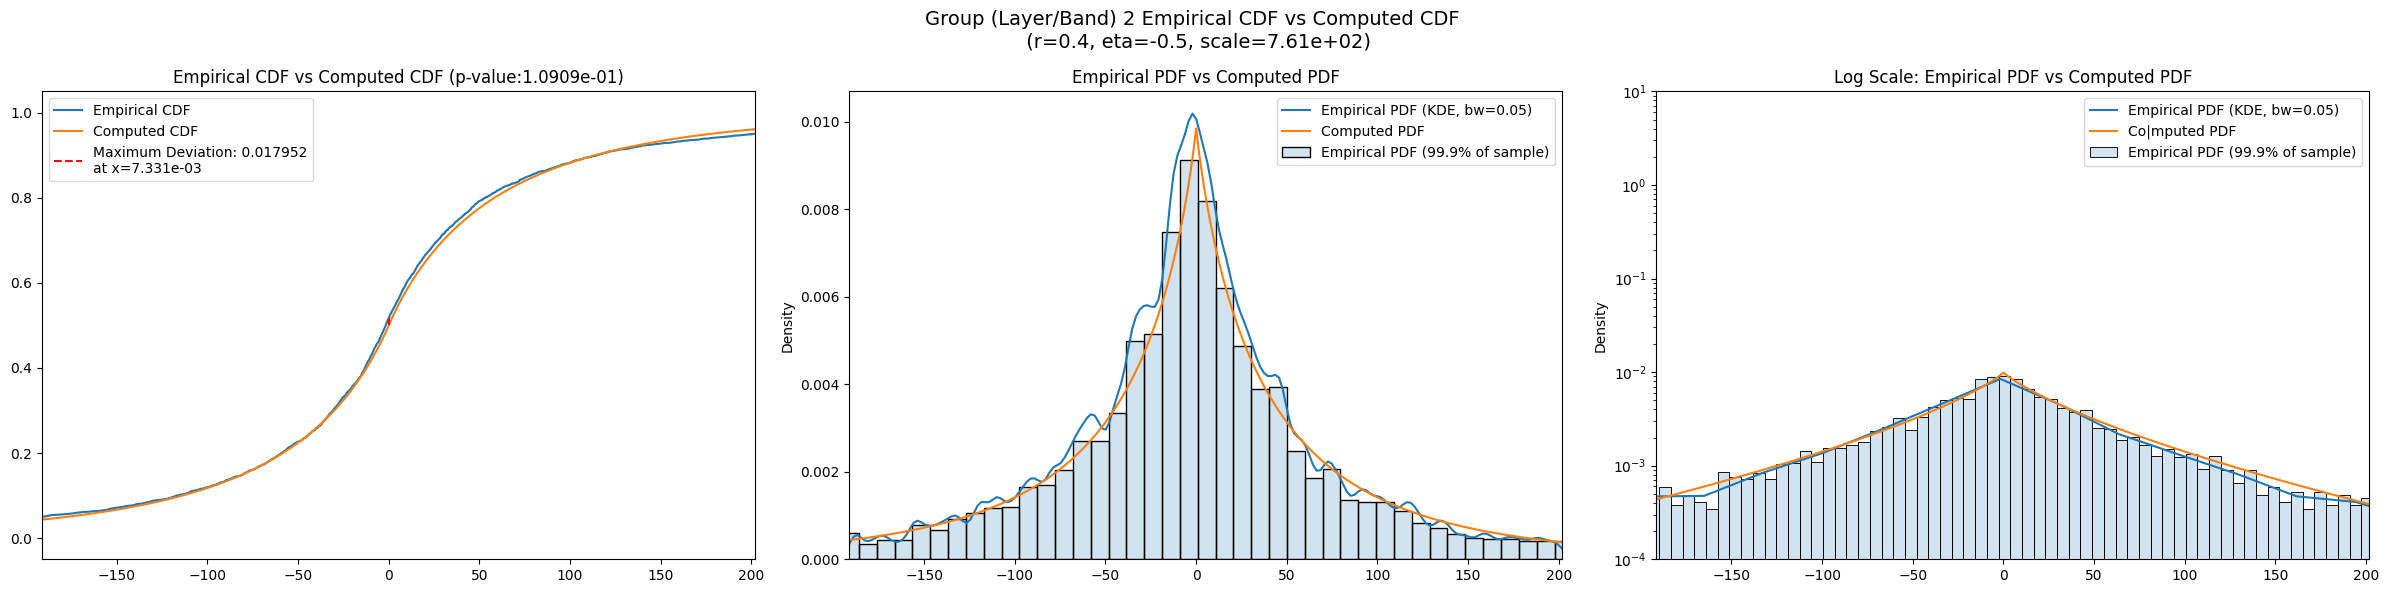

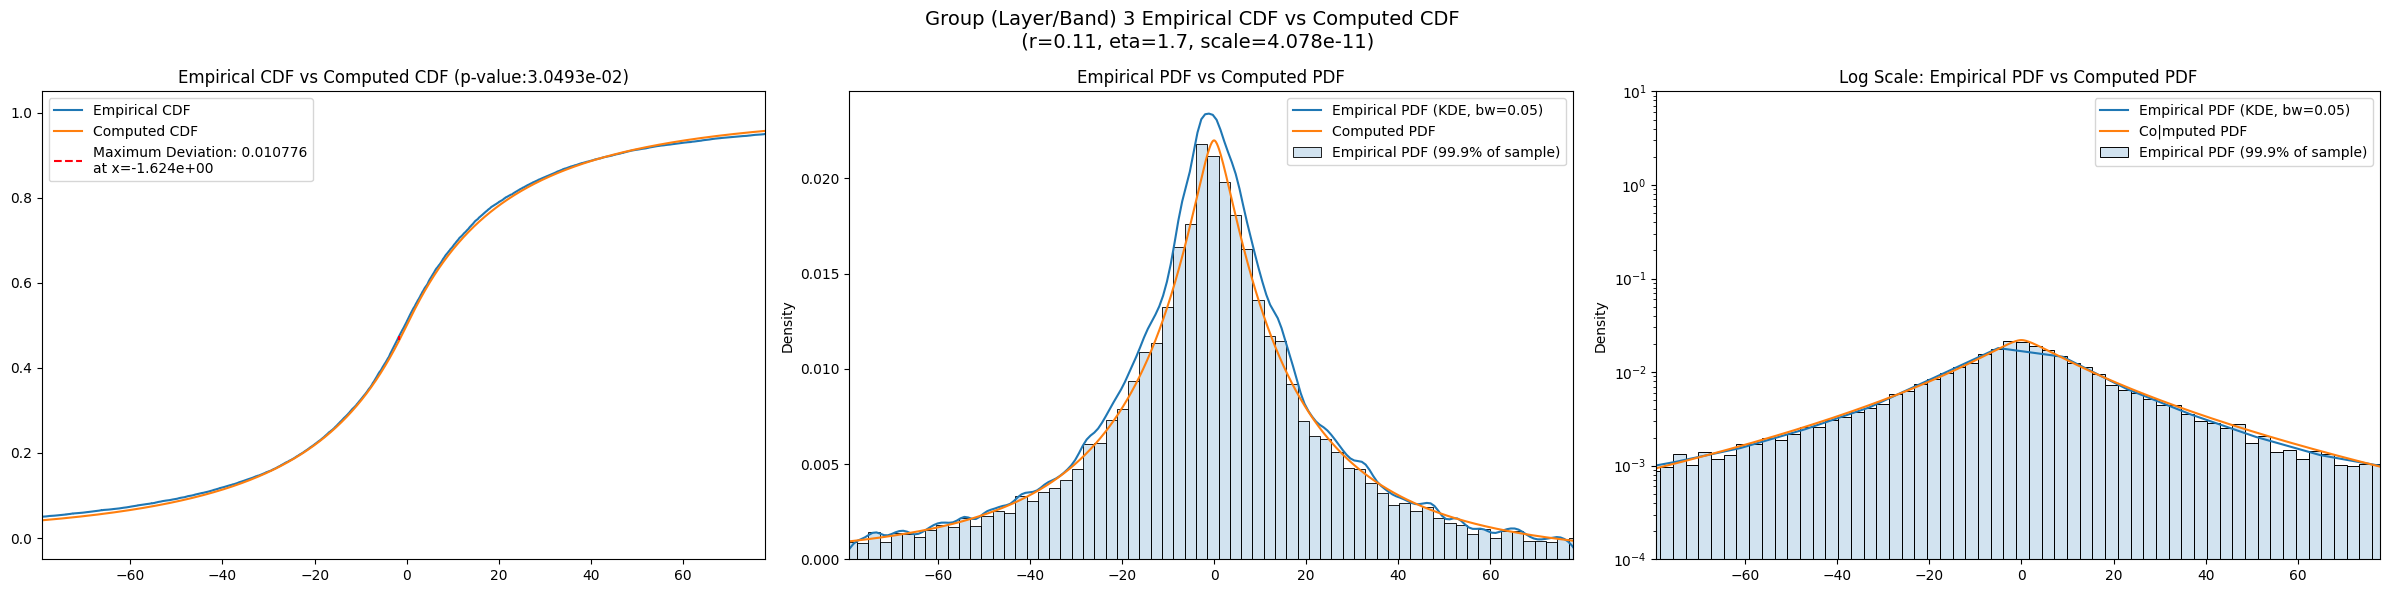

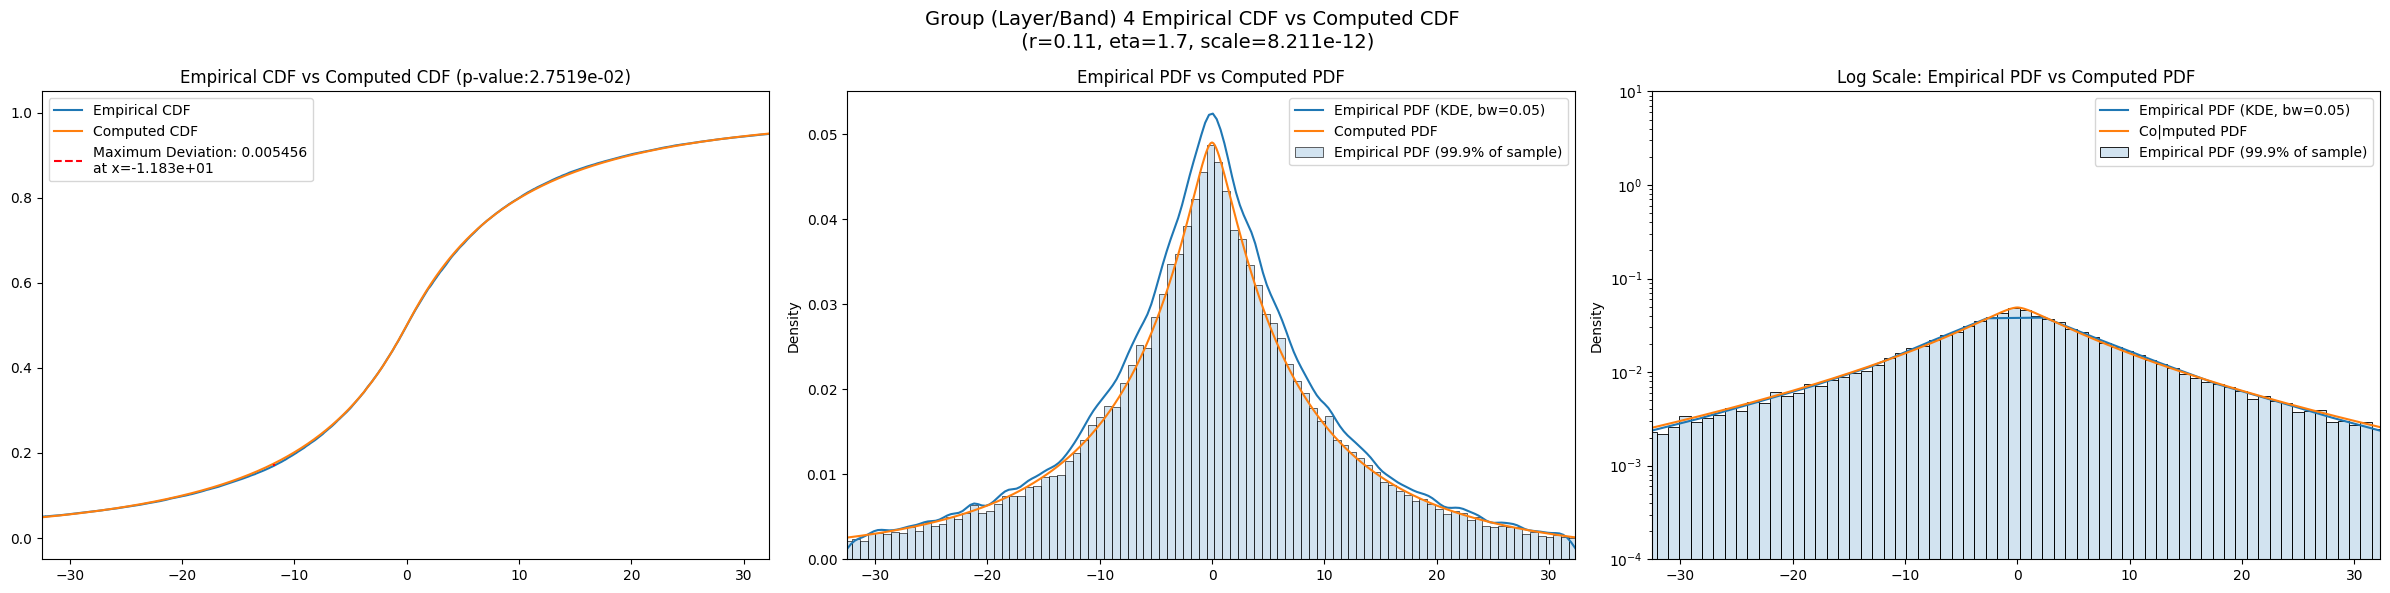

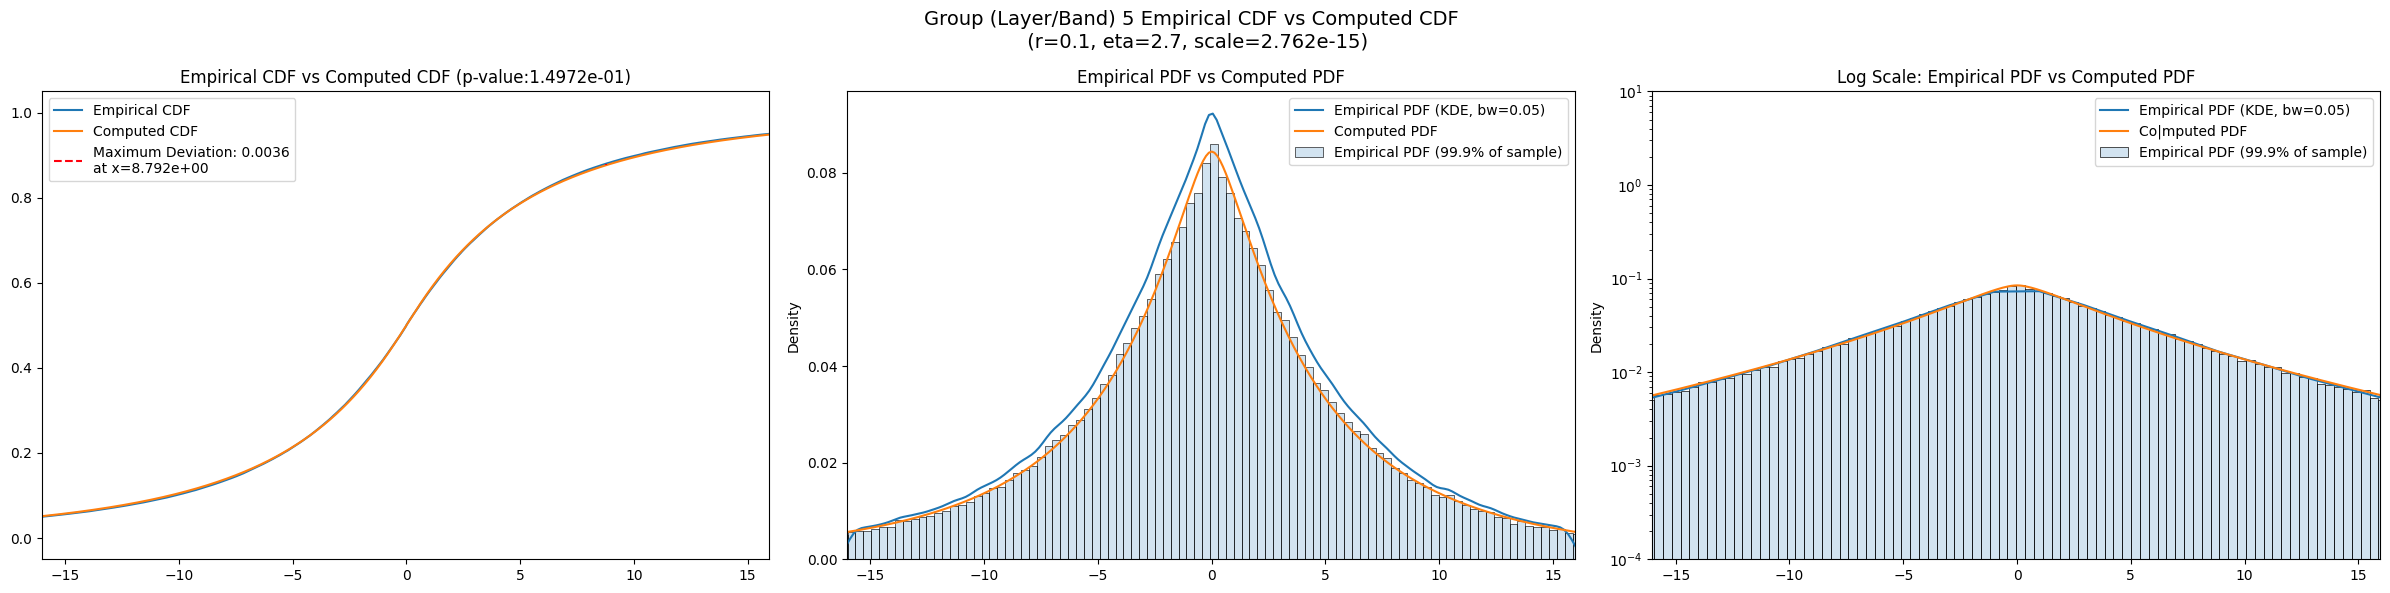

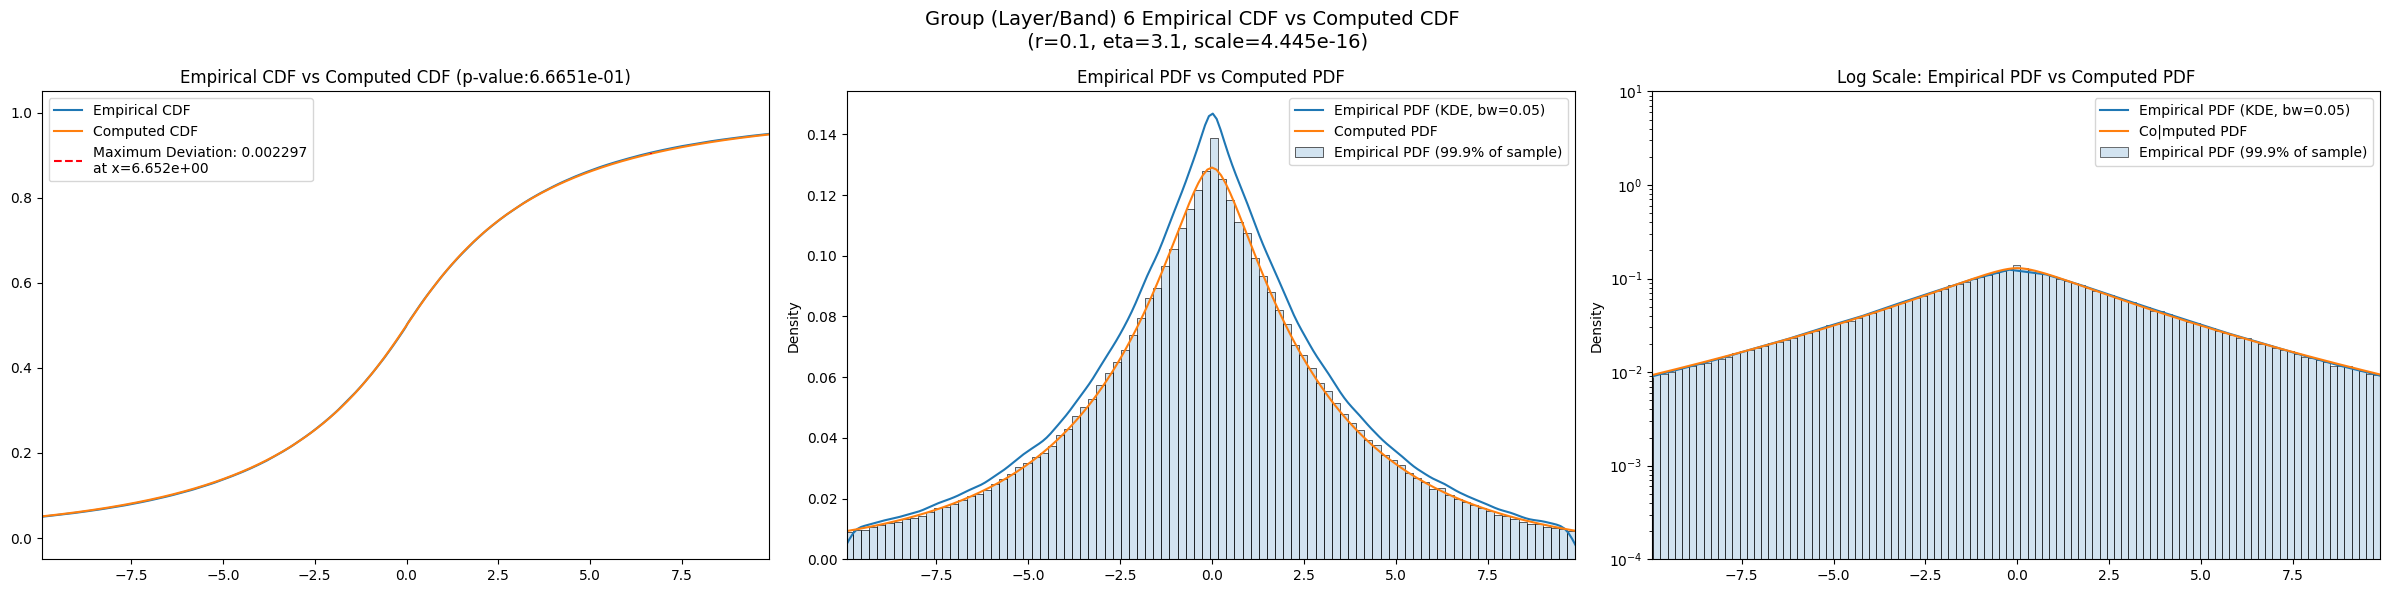

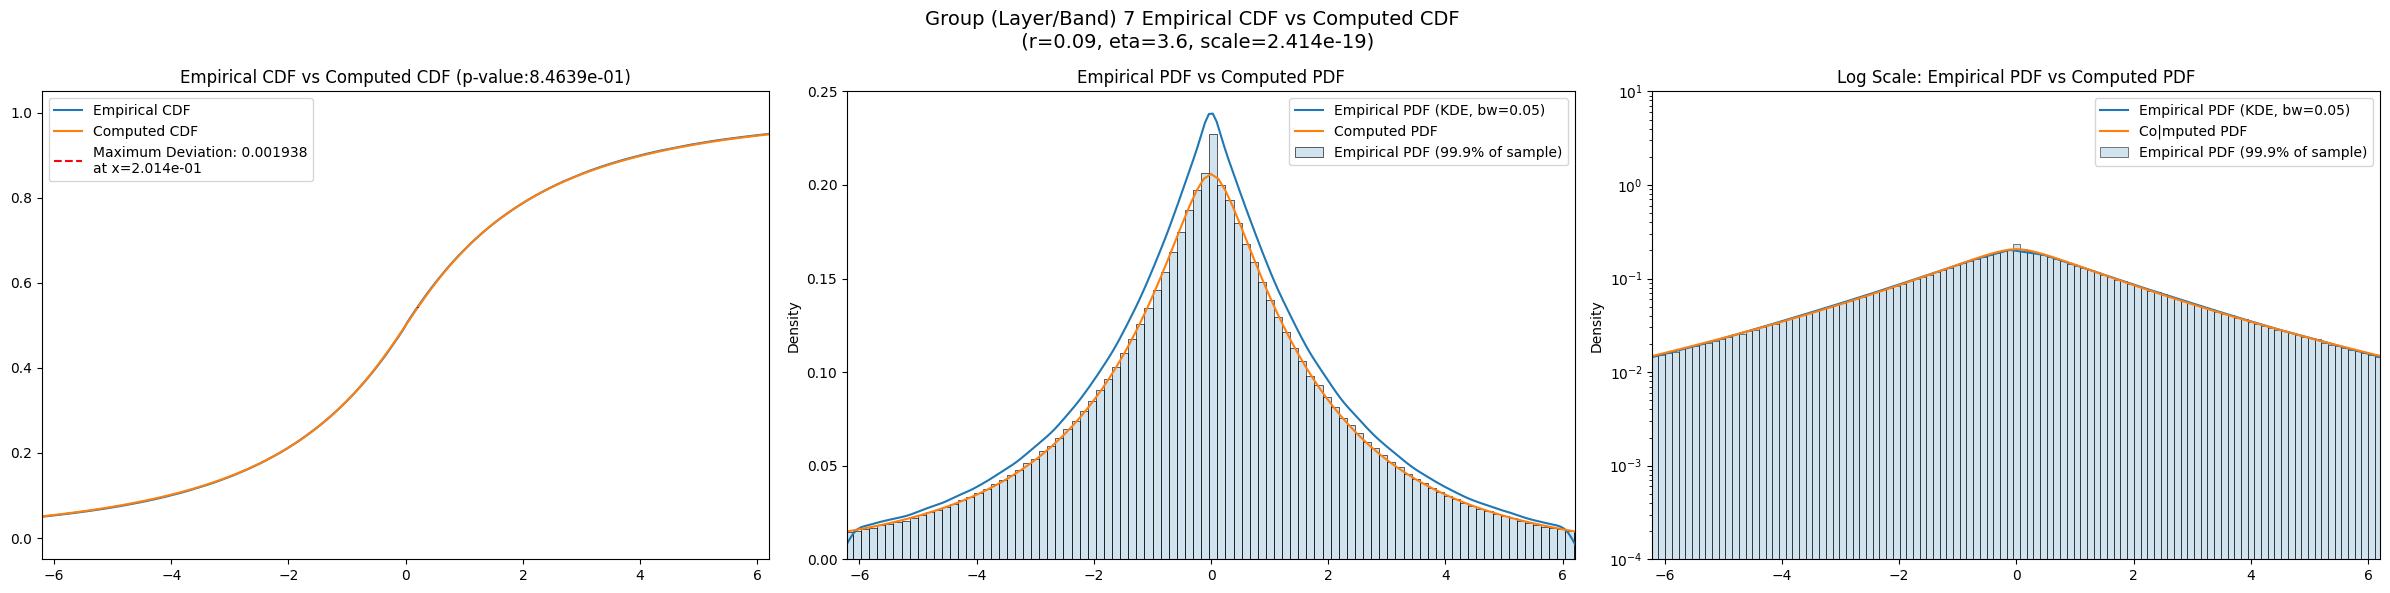

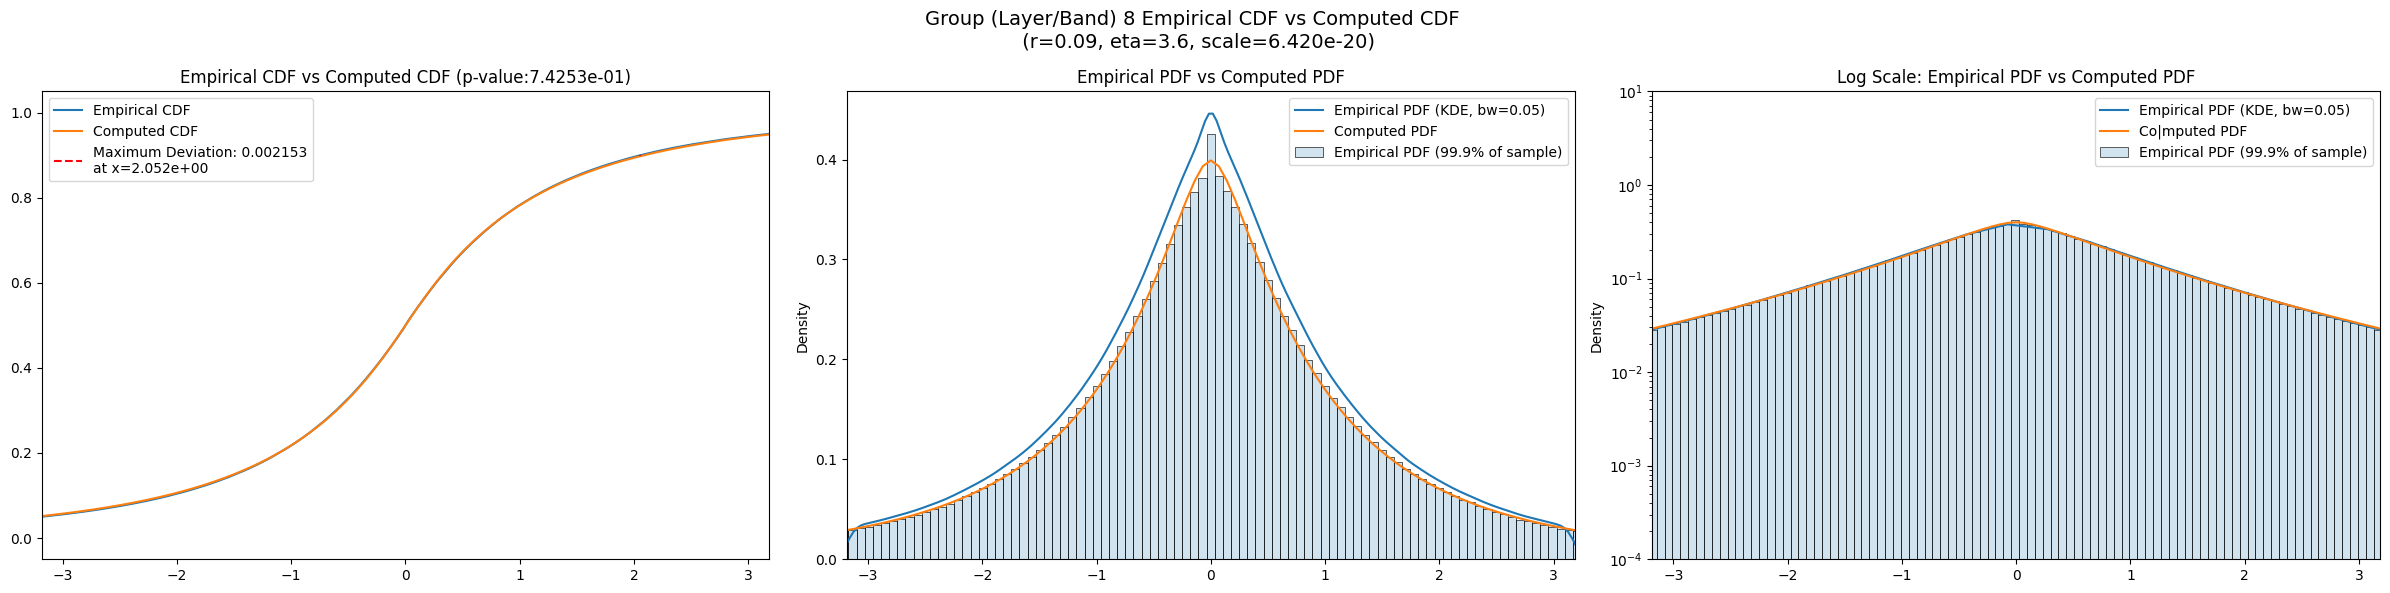

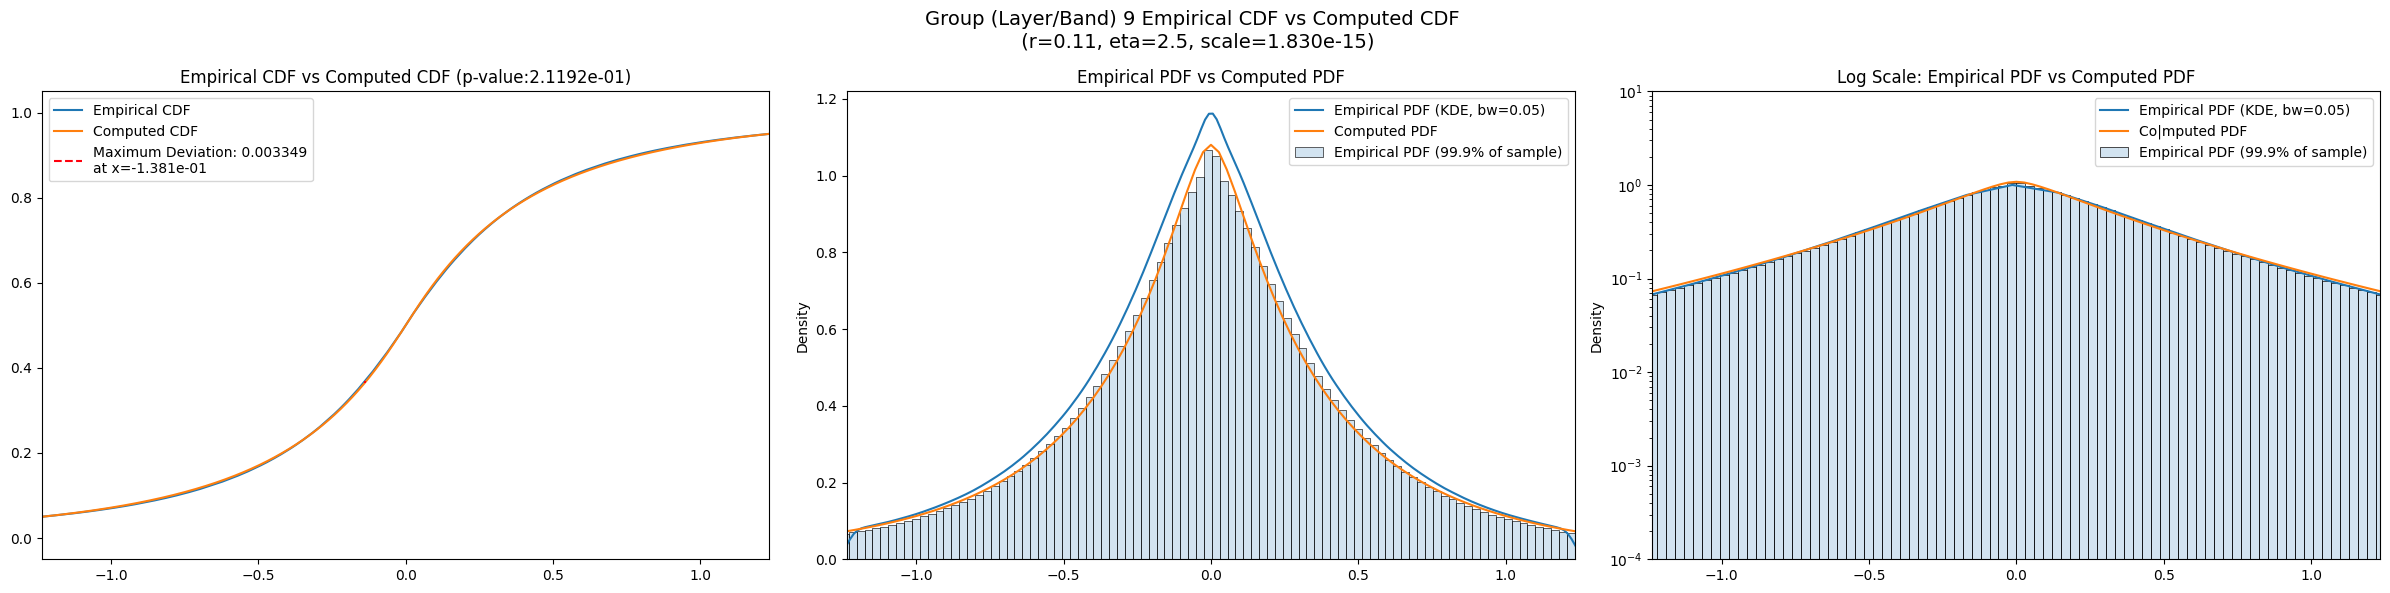

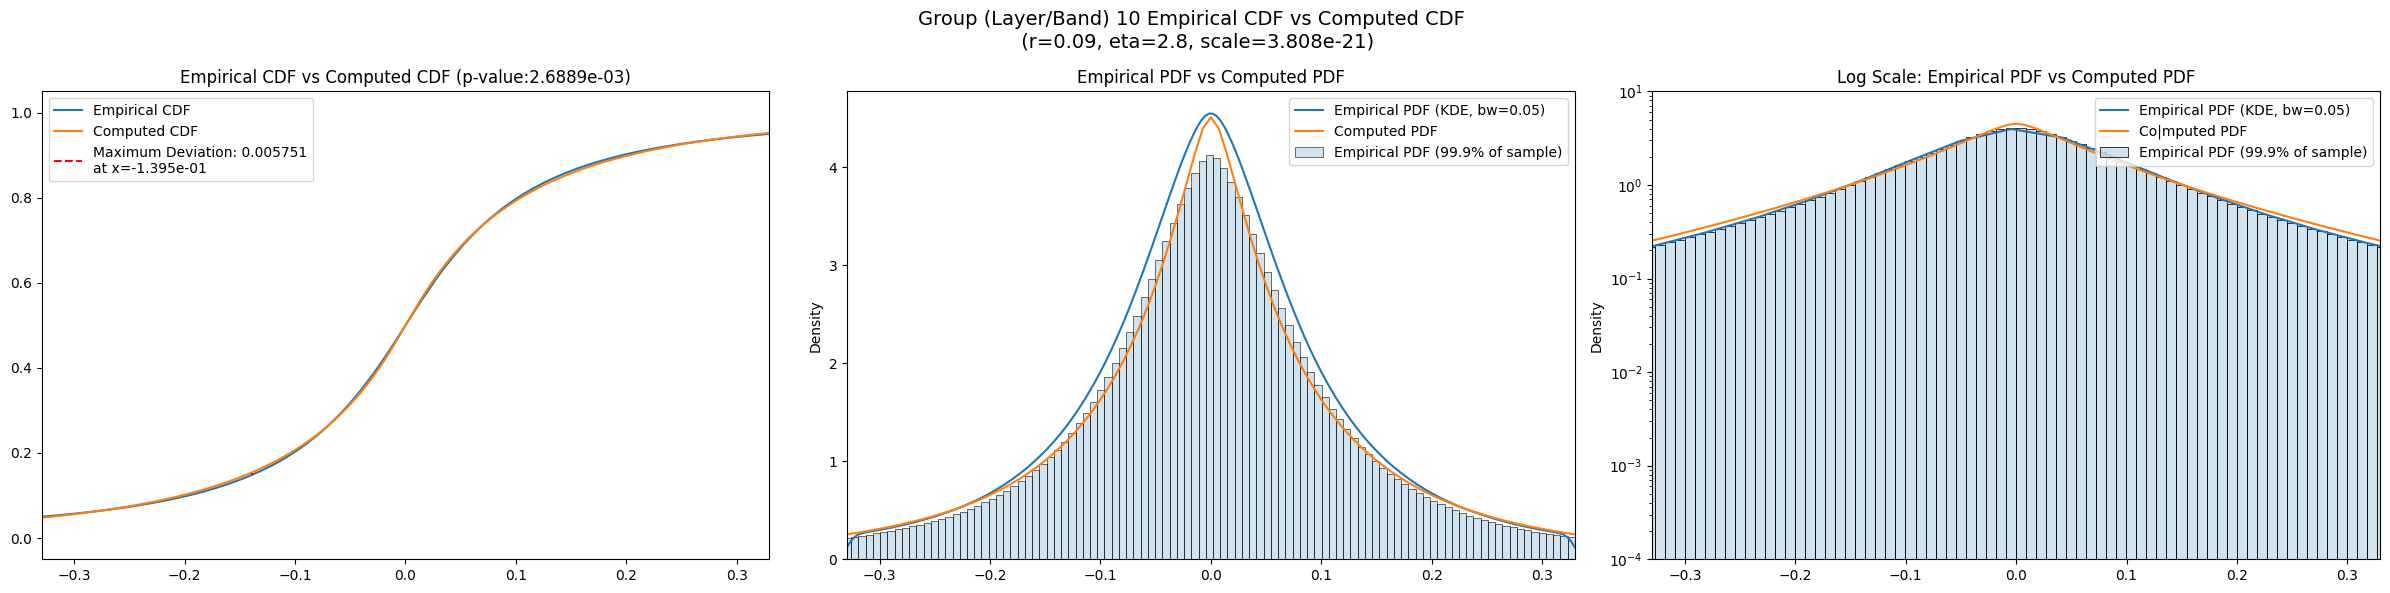

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var     var_lower      var_upper     obs_kurt  kurt_lower  \
layer                                                                       
2      70756.080000  28402.766000  134955.840000    398.59210  158.815230   
3      12470.006000   7129.358000   19865.809000    397.38196  180.391070   
4       3133.784400   1051.340600    9374.212000   3015.76050  126.752686   
5        394.657000    197.559040     996.861000   1540.65990   65.792070   
6        126.877780     62.349678     502.292540   4257.31050   43.438255   
7         44.709316     23.061848     190.406900   4413.49560   35.470478   
8         13.551530      6.597639      45.296257   3008.98000   56.811893   
9          2.821836      1.154131      10.996537   4970.96880   70.242760   
10         0.345311      0.093980       1.822111  10754.93500   84.966545   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2       680.61340         4500.0             0.017928        0.4         -0.5   
3       599.06287        18000.0             0.011000        0.1          2.0   
4      4935.14900        72000.0             0.005548        0.1          2.0   
5      3610.55760       288000.0             0.003218        0.1          2.7   
6      6001.98600      1152000.0             0.002297        0.1          3.1   
7      5876.05660      4608000.0             0.002185        0.1          3.2   
8      4989.76760     18432000.0             0.002013        0.1          3.2   
9      6032.67800     73728000.0             0.003897        0.1          2.8   
10     7796.52540    294912000.0             0.006596        0.1          2.5   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       72.233500              0.056124          9.225760e-13   
3      ...       29.435400              0.053792          1.039300e-45   
4      ...       13.149500              0.046199         5.549390e-134   
5      ...        7.098250              0.039145          0.000000e+00   
6      ...        4.479120              0.037586          0.000000e+00   
7      ...        2.794930              0.037860          0.000000e+00   
8      ...        1.444700              0.037106          0.000000e+00   
9      ...        0.549710              0.038432          0.000000e+00   
10     ...        0.138366              0.042613          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          63.792800             0.030665         4.131590e-04  49.450500   
3          26.028200             0.027233         4.971960e-12  20.590400   
4          11.703200             0.020490         1.086640e-26   9.251980   
5           6.275020             0.013639         5.804510e-47   5.010920   
6           3.959530             0.011757        9.518740e-139   3.166750   
7           2.472880             0.011692         0.000000e+00   1.975040   
8           1.273590             0.011174         0.000000e+00   1.024210   
9           0.486604             0.013764         0.000000e+00   0.387602   
10          0.122654             0.018859         0.000000e+00   0.097601   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.031318   2.868250e-04          1.095156e-01  
3           0.025456   1.447370e-10          3.040668e-02  
4           0.017726   4.404360e-20          4.518022e-02  
5           0.010702   4.446670e-29          5.117572e-03  
6           0.010391  1.814650e-108          1.045327e-05  
7           0.011141   0.000000e+00          1.022898e-14  
8           0.009551   0.000000e+00          1.701913e-51  
9           0.009287   0.000000e+00          0.000000e+00  
10       

## Results

In [18]:
import pandas as pd
import os
master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.017928                 0.020208          0.017928   
3                 0.011000                 0.010113          0.010774   
4                 0.005548                 0.005059          0.005128   
5                 0.003218                 0.002530          0.003218   
6                 0.002297                 0.001265          0.002297   
7                 0.002185                 0.000633          0.001890   
8                 0.002013                 0.000316          0.001786   
9                 0.003897                 0.000158          0.003630   
10                0.006596                 0.000079          0.005834   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.056124             0.030665       0.031318  
3                  0.053792             0.027233       0.025456  
4                  0.046199             0.020490       0.017726  
5                  0.039145             0.013639       0.010702  
6                  0.037586             0.011757       0.010391  
7                  0.037860             0.011692       0.011141  
8                  0.037106             0.011174       0.009551  
9                  0.038432             0.013764       0.009287  
10                 0.042613             0.018859       0.011938

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta    best_scale  \
layer                                                                         
2            13738.998000          0.017928    0.40      -0.5  7.609919e+02   
3             2624.995605          0.010774    0.11       1.7  4.078262e-11   
4              528.526917          0.005128    0.11       1.7  8.211333e-12   
5              128.062040          0.003218    0.10       2.7  2.761877e-15   
6               47.182083          0.002297    0.10       3.1  4.445374e-16   
7               18.622375          0.001890    0.09       3.6  2.413895e-19   
8                4.952874          0.001786    0.09       3.6  6.420083e-20   
9                0.722032          0.003630    0.11       2.5  1.830025e-15   
10               0.051910          0.005834    0.09       2.8  3.807810e-21   

       best_exclude_cutoff  
layer                       
2                     25.0  
3                     75.0  
4                    200.0  
5                    200.0  
6                    150.0  
7                    125.0  
8                    125.0  
9                    225.0  
10                   300.0

In [21]:
eng.quit()